# [Supernovae Data by Astrocatalogs](https://github.com/astrocatalogs/sne-2015-2019)

## Data Description

The data with which we are going to populate our Data Lake is with the **Open Supernovae Catalog (OSC)**. We will use a collection of all discovered supernovae from 2015 to 2019. This repository contains a variety of information about its discovery and physical attributes. For a deeper understanding, see its **[Schema's information](https://github.com/astrocatalogs/schema)**. The data is stored in .JSON files and each file refers to a different supernovae.

First thing first, let us clone the repository inside our data folder. From the main directory, go to data and git clone the following repository there: https://github.com/astrocatalogs/sne-2015-2019.git.

This should create a folder filled with .JSON files called **sne-2015-2019**. Be carefull when managing these files inside Jupyter Lab, this folder is a **CHONK BOY**! **ʕ•ᴥ•ʔ**

Now, we will import a single supernovae data to see what we are working with.

In [1]:
import pandas as pd
import json
import os
import sweetviz as sv

/home/corbanez/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
f = r'../data/sne-2015-2019/ASASSN-15ab.json'

with open(f, 'r') as j:
    raw = json.loads(j.read())


The first key is only the supernovae's name. This could be handfull in case we want to merge every .JSON file into only one gigantic .JSON.

In [3]:
print(raw.keys())
print(list(raw.keys())[0])

dict_keys(['ASASSN-15ab'])
ASASSN-15ab


Once we open the first key, we begin to see every possible information collected from these supernovae. This is where we start to imagine what data structure will correctly fit our needs. Here we stumble on a couple of problems. Firstly, these measurement can have multiple values from differents observations. For instance, the **dec** key has two possible values from distinct sources. Secondly, by looking at our [Schema](https://github.com/astrocatalogs/schema) we see multiple attributes that are not present in the supernovae we are analysing. This could be a barrier when recursively creating a **DataFrame**.

In [4]:
print(raw['ASASSN-15ab'].keys())

dict_keys(['schema', 'name', 'sources', 'alias', 'claimedtype', 'comovingdist', 'dec', 'discoverdate', 'discoverer', 'ebv', 'host', 'hostdec', 'hostoffsetang', 'hostoffsetdist', 'hostra', 'lumdist', 'maxabsmag', 'maxappmag', 'maxdate', 'maxvisualabsmag', 'maxvisualappmag', 'maxvisualdate', 'ra', 'redshift', 'velocity', 'photometry'])


In [5]:
for key in raw['ASASSN-15ab']:
    value = raw['ASASSN-15ab'][key]
    # if isinstance(value, list):
    #      value = value[0]
    # else:
    #      value = value
    print(f'{key} : {value}\n\n')

schema : https://github.com/astrocatalogs/supernovae/blob/d3ef5fc/SCHEMA.md


name : ASASSN-15ab


sources : [{'name': '2016A&A...594A..13P', 'bibcode': '2016A&A...594A..13P', 'reference': 'Planck Collaboration et al. (2016)', 'alias': '1'}, {'name': '2015ATel.6864....1D', 'bibcode': '2015ATel.6864....1D', 'reference': 'Dong et al. (2015)', 'alias': '2'}, {'name': '2015ATel.6882....1S', 'bibcode': '2015ATel.6882....1S', 'reference': 'Shappee et al. (2015)', 'alias': '3'}, {'name': '2011ApJ...737..103S', 'bibcode': '2011ApJ...737..103S', 'reference': 'Schlafly & Finkbeiner (2011)', 'alias': '4'}, {'name': 'ASAS-SN Supernovae', 'url': 'http://www.astronomy.ohio-state.edu/~assassin/sn_list.html', 'alias': '5'}, {'name': 'Latest Supernovae', 'secondary': True, 'url': 'http://www.rochesterastronomy.org/snimages/snredshiftall.html', 'alias': '6'}, {'name': 'The Open Supernova Catalog', 'bibcode': '2017ApJ...835...64G', 'reference': 'Guillochon et al. (2017)', 'secondary': True, 'url': 'https

By looking at the data from multiple supernovae, we've figured that the best way to build a database is to slip our data into a relational and a non-relational set. For instance, the following fields are well behaved and could be structured as a relational database.

```
alias, claimedtype, comovingdist, dec, discoverdate, discoverer, ebv, host, hostdec, hostoffsetang, hostoffsetdist, hostra, lumdist, maxabsmag, maxappmag, maxdate, maxvisualabsmag, maxvisualappmag, maxvisualdate, ra, redshift, velocity
```

Even if some of them have two distinct values - e.g., ```dec``` and ```ra``` - we will pick the first one for simplicity.

On the contrary, fields such as ```photometry, spectra, X-ray,``` and  ```radio``` are multidimensional with a single key (supernovae's name). Therefore, they are candidates to their own non-relational sub database, where they are indexed with the supernovae's name. We are going to use **AWS Redshift** to create the relational database, and **MongoDB** for the .JSON based database.

## Relational Data Transformation

Throughout the beginning of this course, we will only use the relational part of this data. Therefore, the first step is to create a function capable of turning all these values into columns with their respective data. Following the documentation from **Pandas** on the function ```read_json``` [[DOC]](https://pandas.pydata.org/pandas-docs/version/1.1.2/reference/api/pandas.read_json.html), we are going to create a list like object with the pattern

```
[{column -> value}, ... , {column -> value}] 
```

In [6]:
def linearization(raw: dict, non_relational: list) -> pd.DataFrame:
    
    '''
    This function takes a perfectly fine .JSON and transforms it into shit
    '''
    
    
    prime = list(raw.keys())[0]
    idx = 1
    index = {}
    for sup in raw:
        temp = {}
        for key in raw[sup]:
            if key in non_relational:
                pass
            else:
                value = raw[sup][key]
                if isinstance(value, list):
                    value = value[0]
                    for sec_key in value:
                        if sec_key == 'source':
                            pass
                        else:
                            temp[key + '_' + sec_key] = value[sec_key]
                    index[idx] = temp
        idx += 1
                    
    return pd.DataFrame.from_dict(index, orient = 'index')
        

In [7]:
df = linearization(raw, ['photometry', 'source'])

df

sources_name      sources_bibcode  \
1  2016A&A...594A..13P  2016A&A...594A..13P   

                    sources_reference sources_alias  alias_value  \
1  Planck Collaboration et al. (2016)             1  ASASSN-15ab   

  claimedtype_value comovingdist_value  comovingdist_derived  \
1               IIn               78.5                  True   

  comovingdist_u_value    dec_value  ... maxvisualabsmag_derived  \
1                  Mpc  -38:28:29.9  ...                    True   

  maxvisualappmag_value maxvisualappmag_derived maxvisualdate_value  \
1                  15.4                    True          2015/01/06   

   maxvisualdate_derived     ra_value ra_u_value redshift_value  \
1                   True  14:03:06.24      hours         0.0178   

   velocity_value velocity_u_value  
1            5290             km/s  

[1 rows x 46 columns]

The functions is working properly, but our raw file has only one primary key (ASASSN-15ab). Therefore, before we linearize a row, we should create a broader dict with multiple supernovaes. First of all, let us import a new set of data to make sure our function can handle multiple primary keys.

In [8]:
f2 = r'../data/sne-2015-2019/ASASSN-15ar.json'

with open(f2, 'r') as j:
    raw2 = json.loads(j.read())

In [9]:
temp = {}

temp[list(raw2.keys())[0]] = raw2[list(raw2.keys())[0]]
temp[list(raw.keys())[0]] = raw[list(raw.keys())[0]]

In [10]:
df = linearization(temp, ['photometry', 'spectra'])

In [11]:
df

sources_name      sources_bibcode  \
1  2016A&A...594A..13P  2016A&A...594A..13P   
2  2016A&A...594A..13P  2016A&A...594A..13P   

                    sources_reference sources_alias  alias_value  \
1  Planck Collaboration et al. (2016)             1  ASASSN-15ar   
2  Planck Collaboration et al. (2016)             1  ASASSN-15ab   

  claimedtype_value comovingdist_value  comovingdist_derived  \
1                Ia              126.7                  True   
2               IIn               78.5                  True   

  comovingdist_u_value     dec_value  ... redshift_value velocity_value  \
1                  Mpc  +10:23:03.87  ...        0.02882           8516   
2                  Mpc   -38:28:29.9  ...         0.0178           5290   

  velocity_u_value hostdec_value  hostdec_derived hostdec_u_value  \
1             km/s           NaN              NaN             NaN   
2             km/s     -38:28:31             True         degrees   

  hostoffsetdist_value hostra_value hostra_derived hostra_u_value  
1                  NaN          NaN            NaN            NaN  
2                 9.67   14:03:08.5           True          hours  

[2 rows x 50 columns]

Great! The function can check differents keys, and rotate the dictionary to a DataFrame. Now, we need a new function to recursively add new .JSON files into a temporary dictionary. Something simple should do the trick

In [12]:
def merger(directory: str) -> dict:
    
    files = os.listdir(directory)
    
    temp = {}
    
    for file in files:
        if file[-5::] != '.json':
            continue
        f = directory + r'/' + file
        with open(f, 'r') as j:
            raw = json.loads(j.read())
        temp[list(raw.keys())[0]] = raw[list(raw.keys())[0]]
    
    return temp

Finally, we execute both functions with their respective arguments and save the **DataFrame** to a .csv file. Remember, this notebook is just an exploration of the data and a brainstorming session on how to create a relational database with this catalog. We will use our discoveries to create a python executor capable of taking data stored in a landing folder on **S3**, remaking these transformations, and placing the treated file in a staging area.

In [13]:
raw = merger(r'../data/sne-2015-2019')

df = linearization(raw, ['photometry', 'spectra'])

df.to_csv(r'../data/stage/supernovae.csv', index = False)

### Exploratory Data Analysis

Now that we have readable data, we can do a basic EDA. I'll be using a package called **SweetViz**, which will really simplify our job.

In [14]:
my_dataframe = pd.read_csv(r'../data/stage/supernovae.csv')

/tmp/ipykernel_24124/1756430743.py:1: DtypeWarning: Columns (62,63,64,65,66,67,68,69,71,82,84,86) have mixed types. Specify dtype option on import or set low_memory=False.
  my_dataframe = pd.read_csv(r'../data/stage/supernovae.csv')


In [15]:
report = sv.analyze(my_dataframe)

Feature: claimedtype_value                   |▏ | [  7%]   00:00 -> (00:05 left)/home/corbanez/.local/lib/python3.8/site-packages/sweetviz/utils.py:34: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clamped_series = clamped_series.append(other_series, ignore_index=False)
/home/corbanez/.local/lib/python3.8/site-packages/sweetviz/utils.py:34: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clamped_series = clamped_series.append(other_series, ignore_index=False)
/home/corbanez/.local/lib/python3.8/site-packages/sweetviz/utils.py:34: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clamped_series = clamped_series.append(other_series, ignore_index=False)
Feature: maxband_value                       |▉ | [ 49%]   00:05 -> (00:08 le


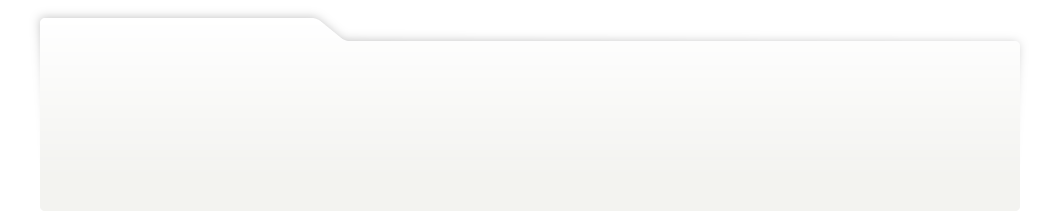
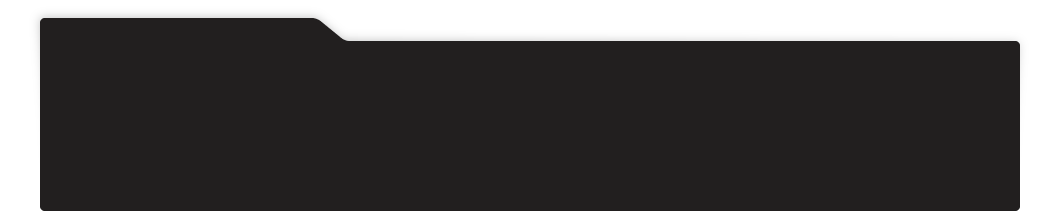
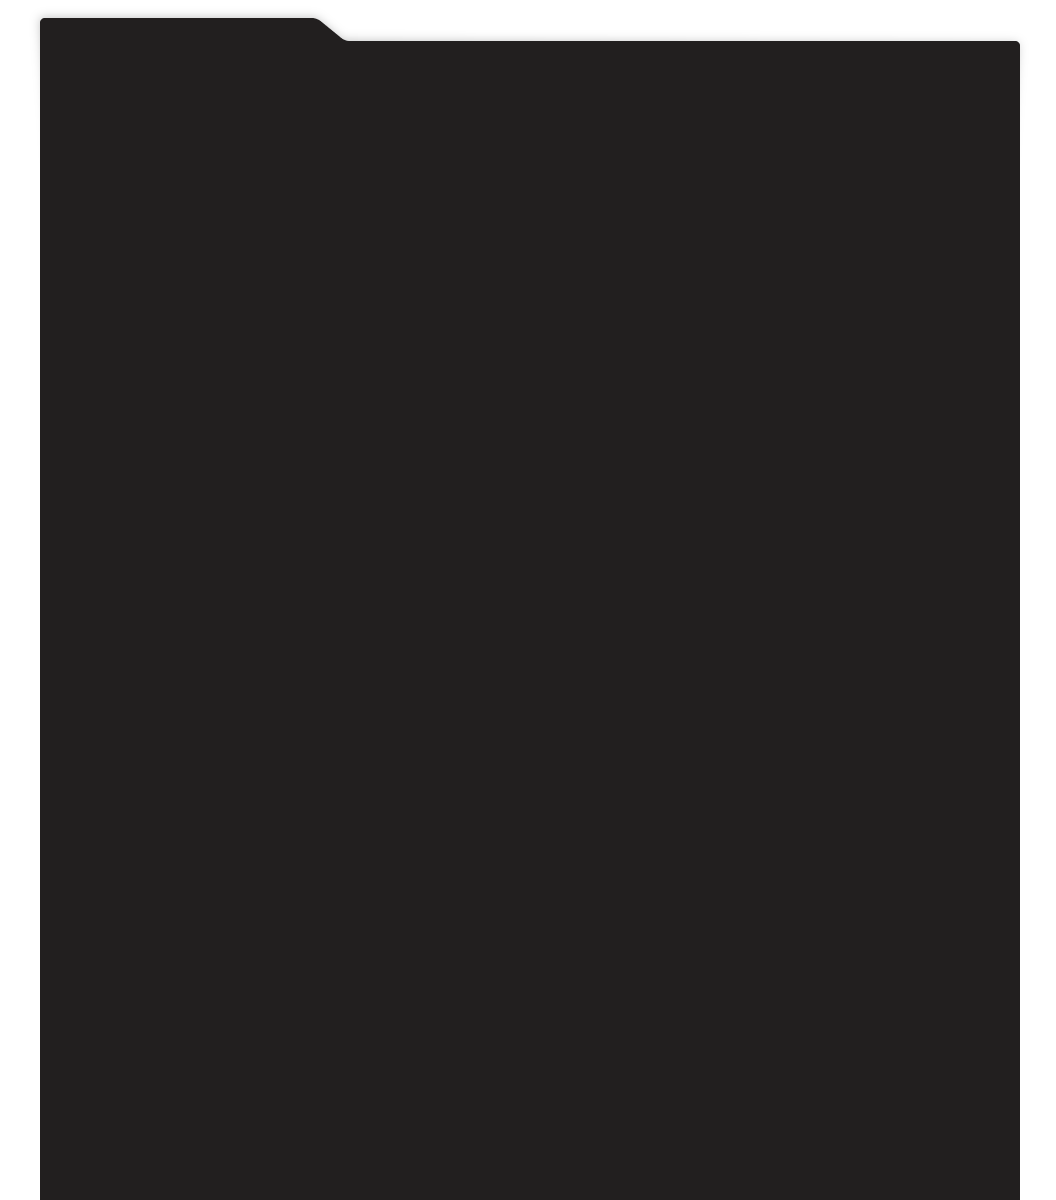
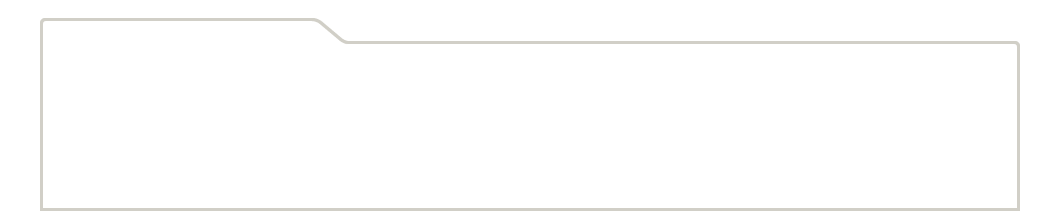
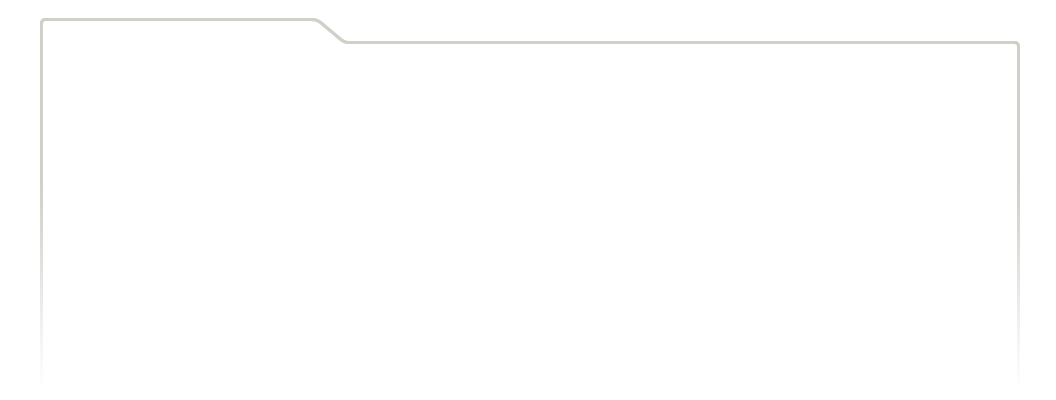
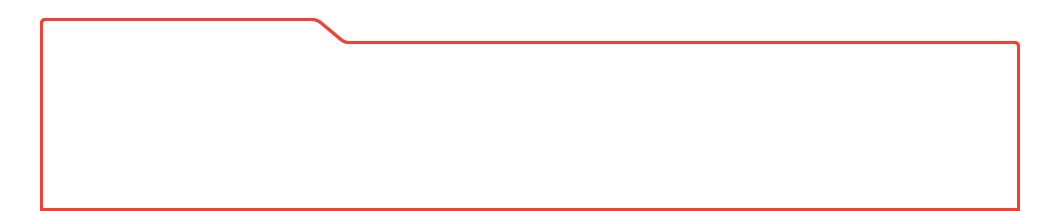
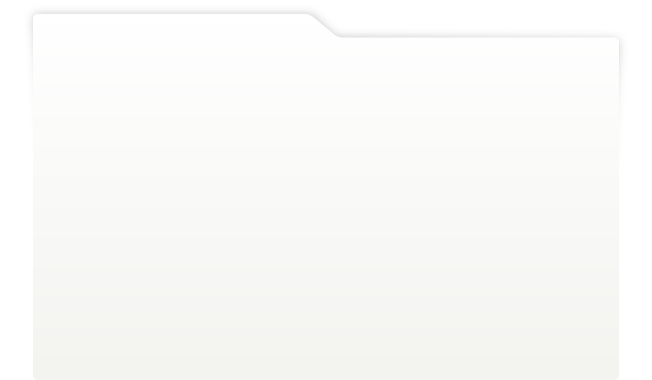
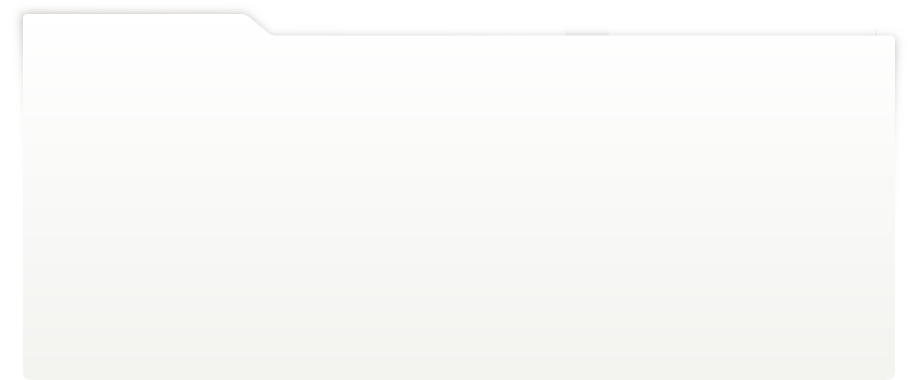
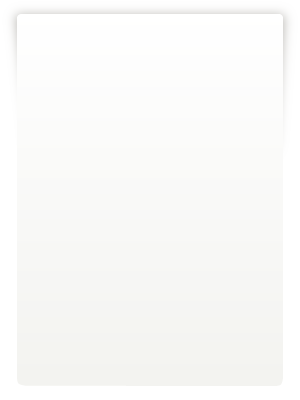
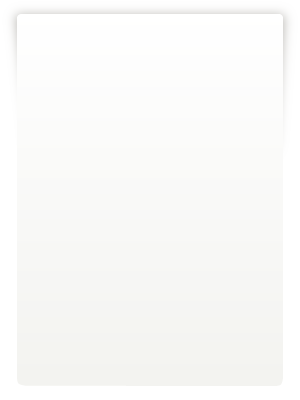
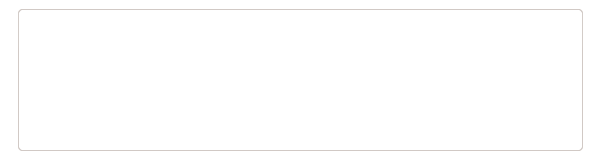
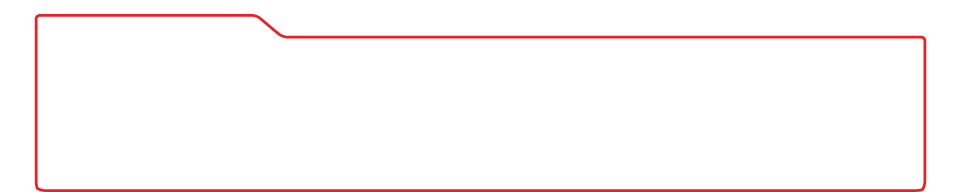
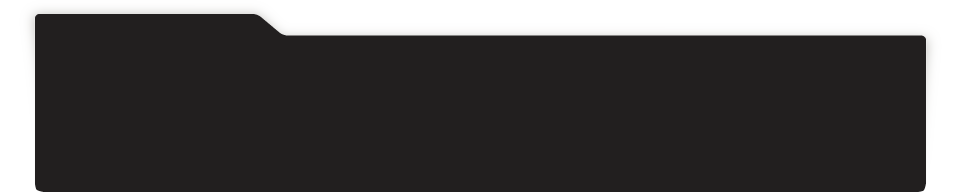
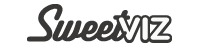
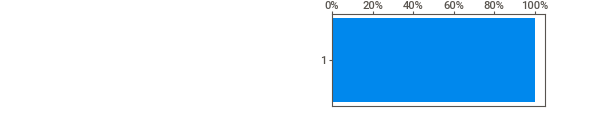
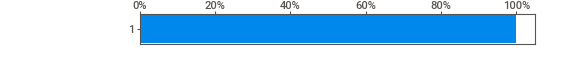
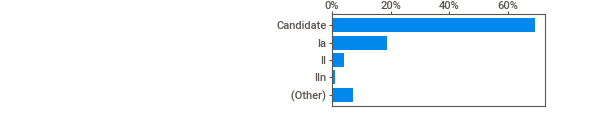
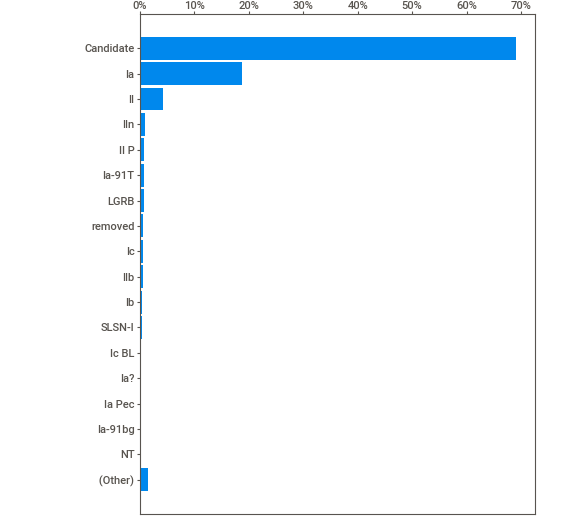
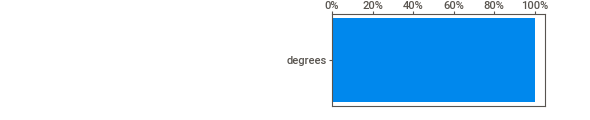
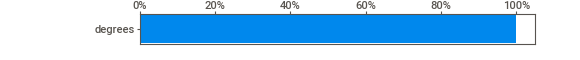
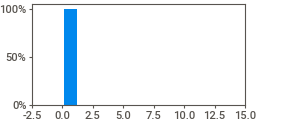
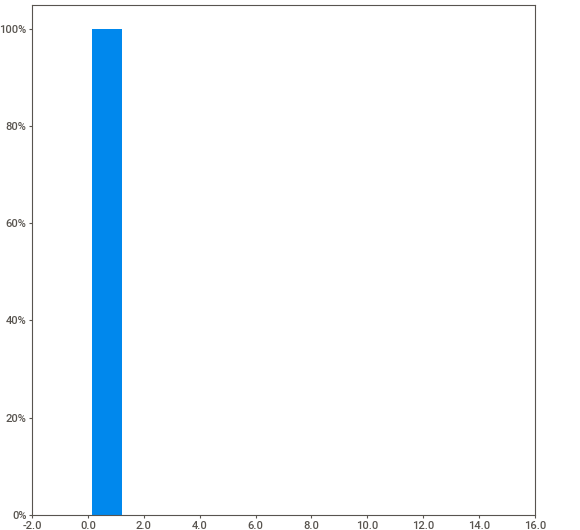
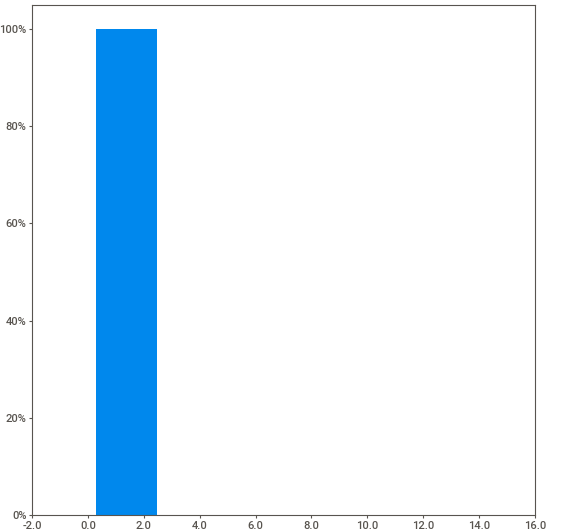
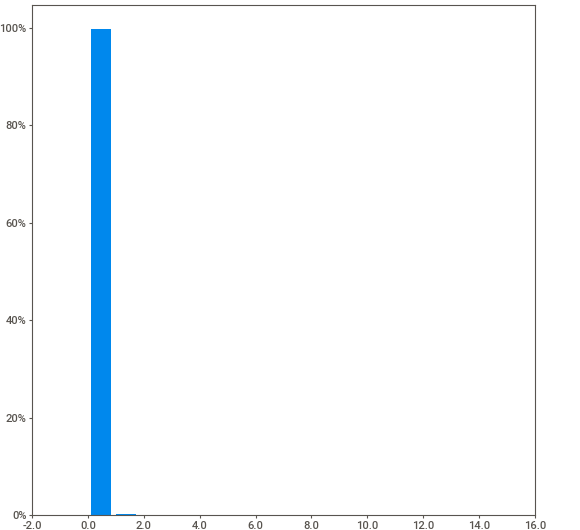
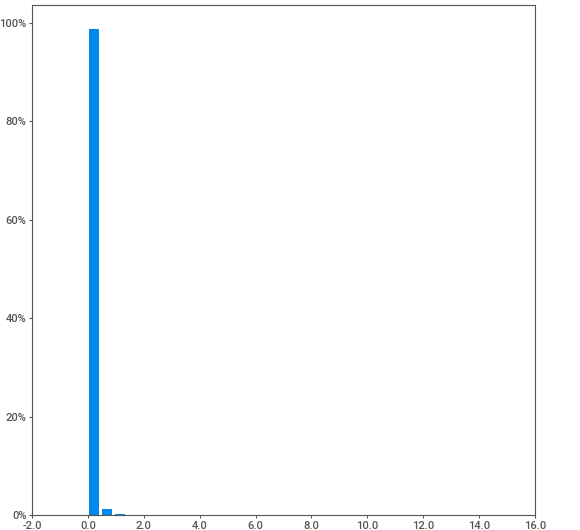
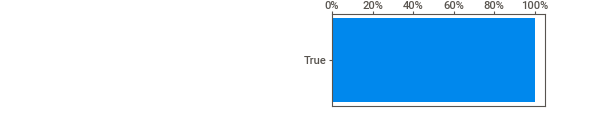
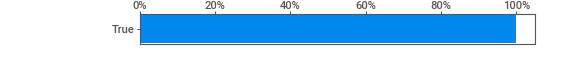
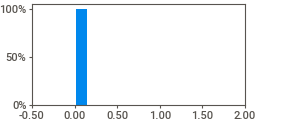
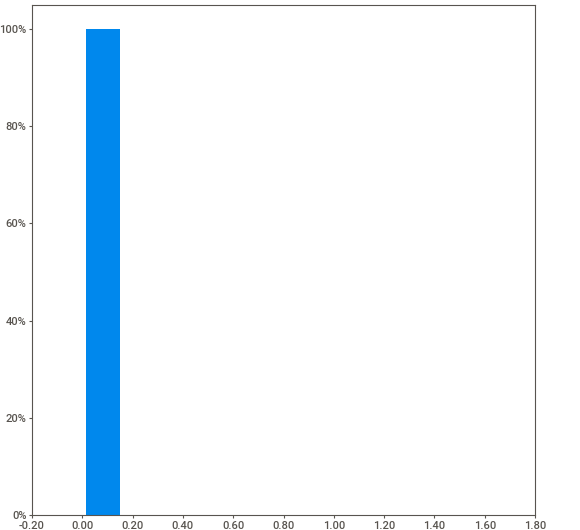
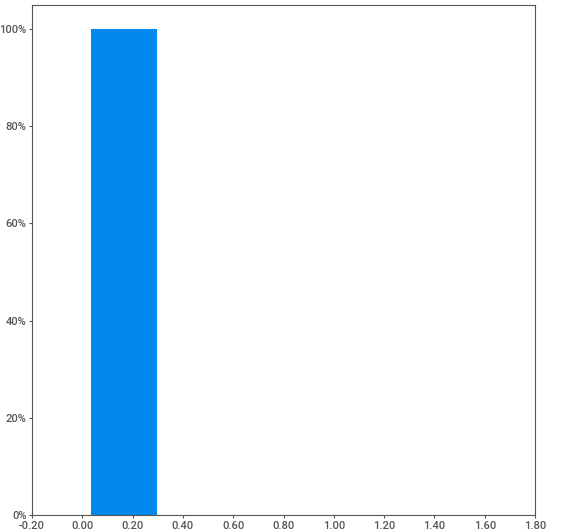
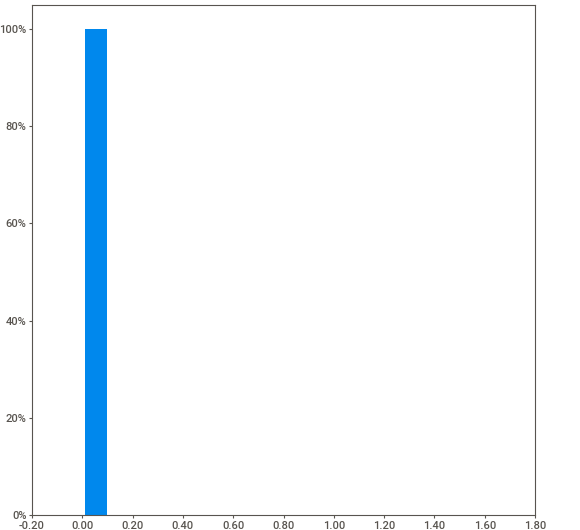
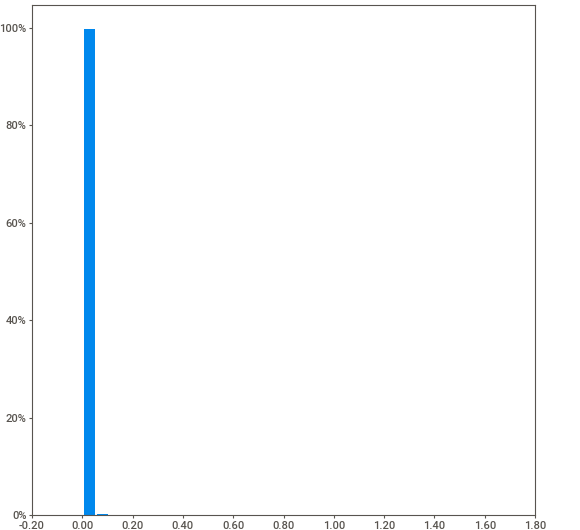
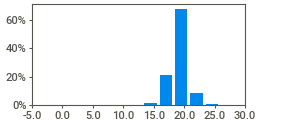
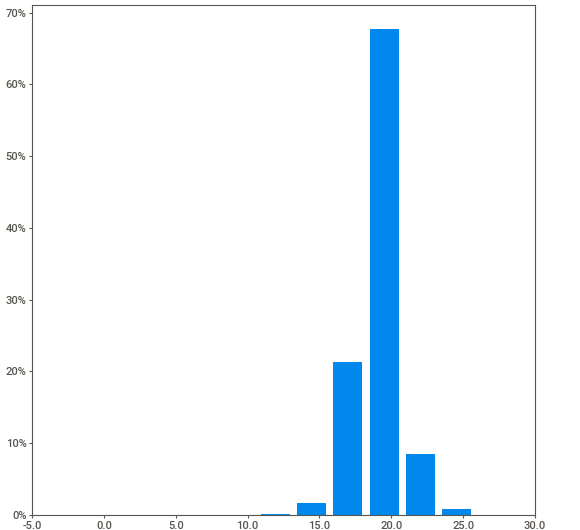
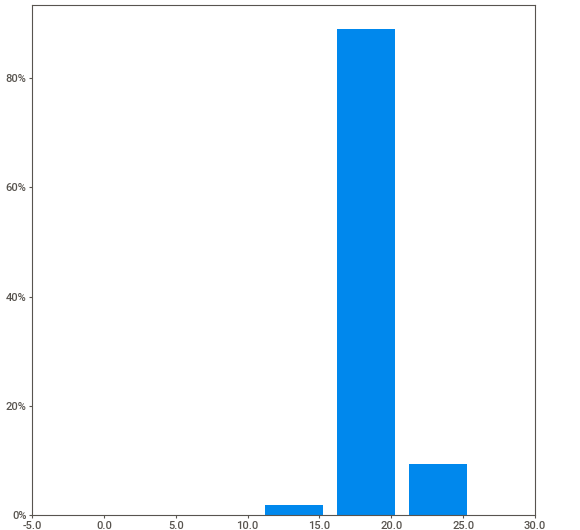
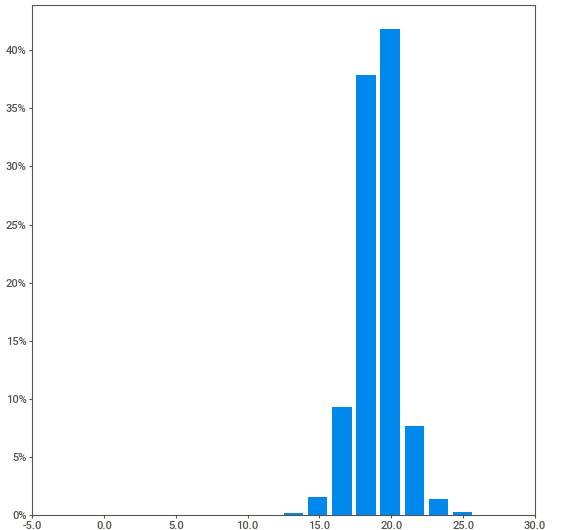
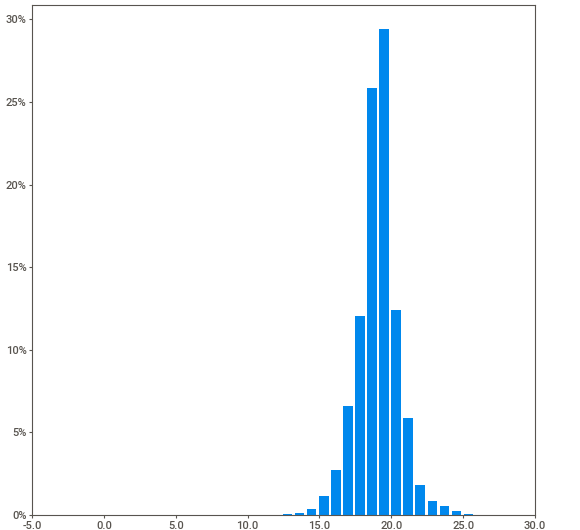
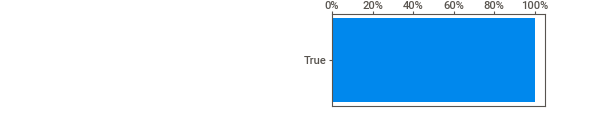
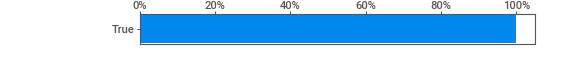
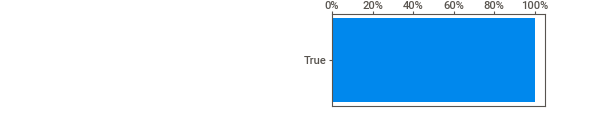
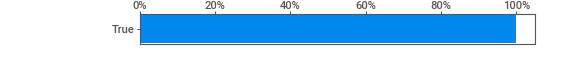
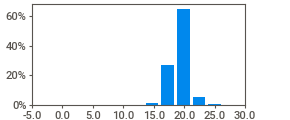
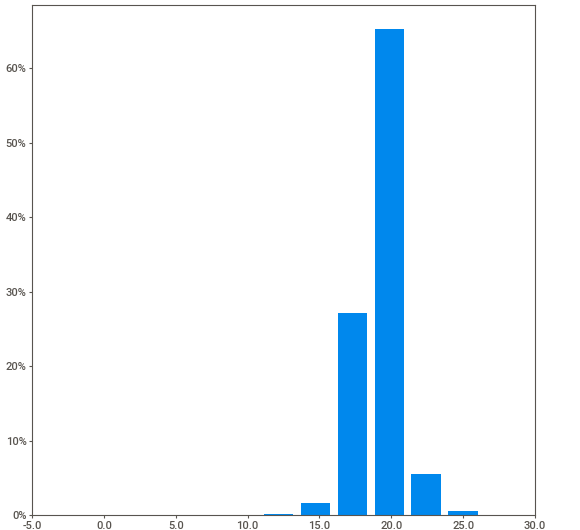
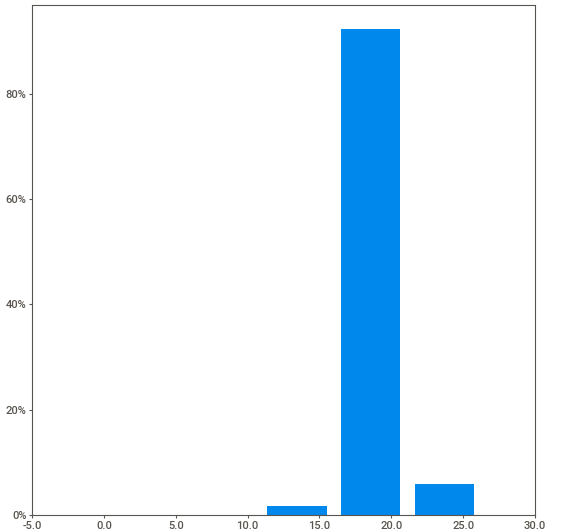
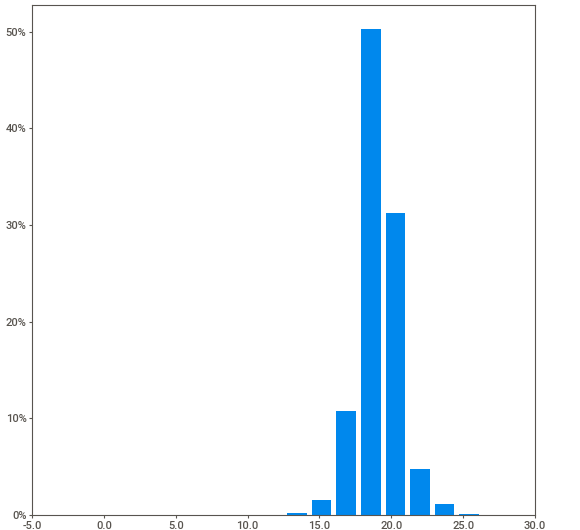
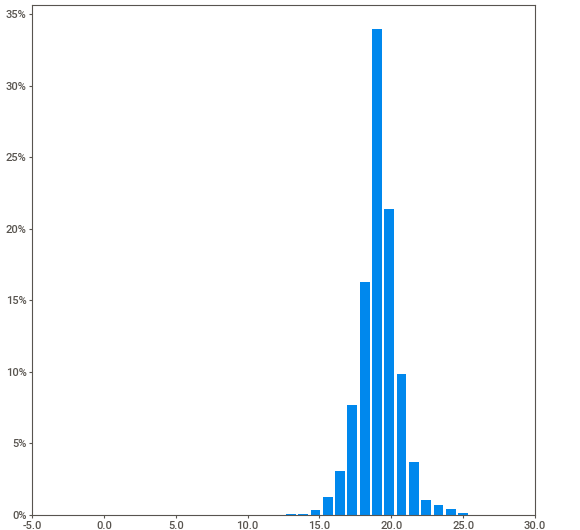
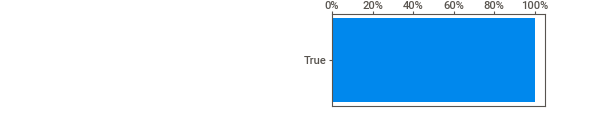
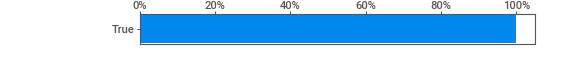
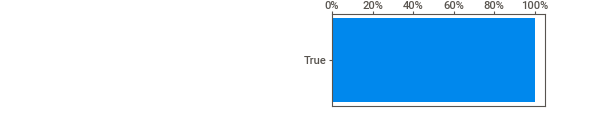
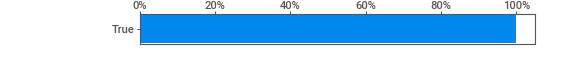
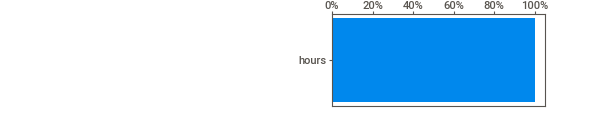
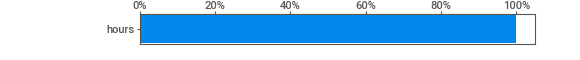
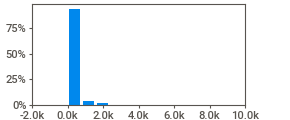
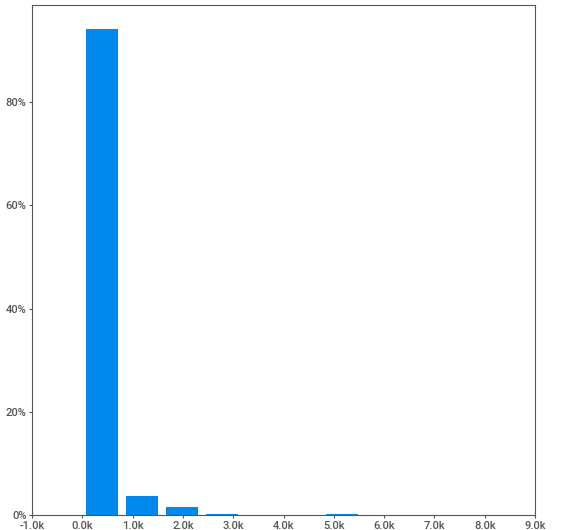
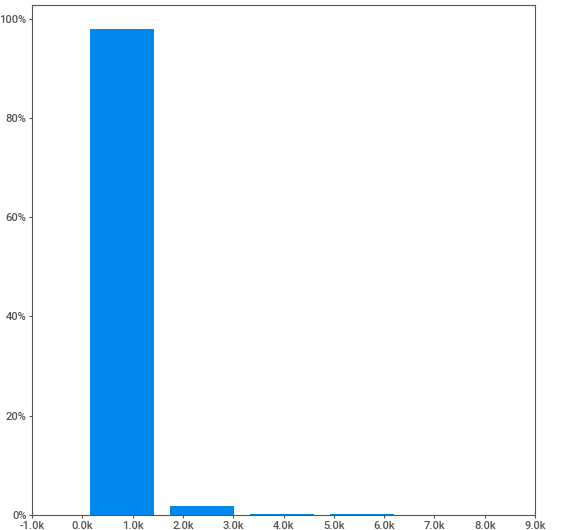
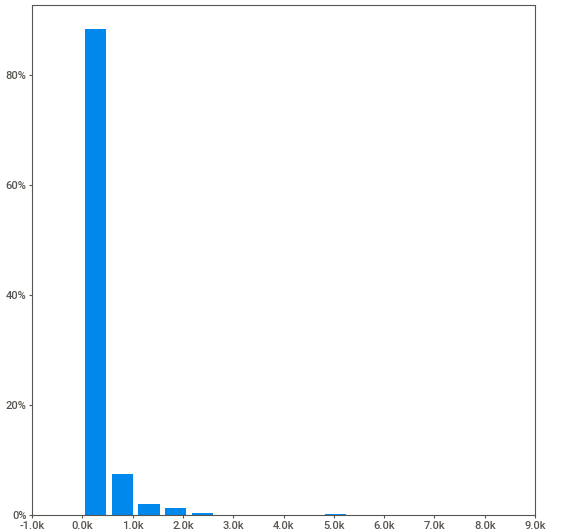
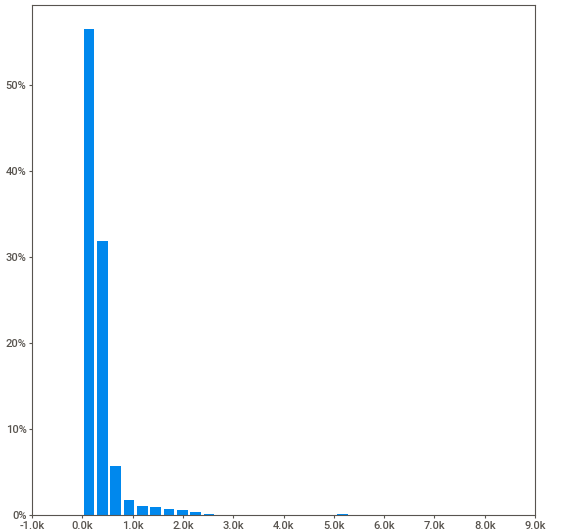
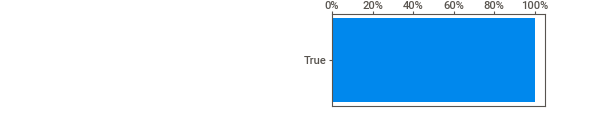
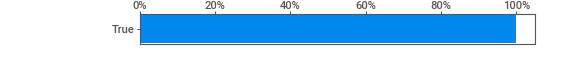
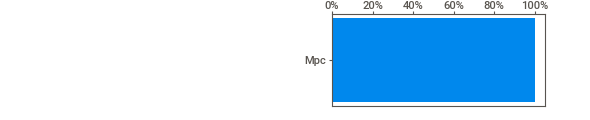
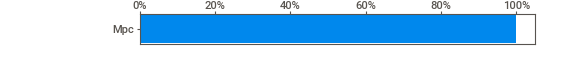
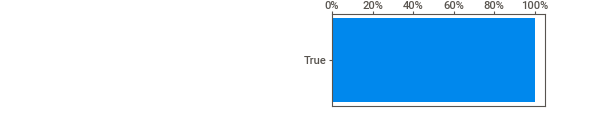
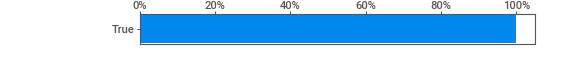
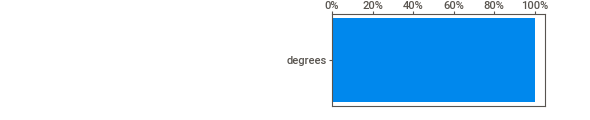
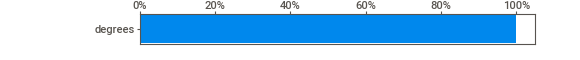
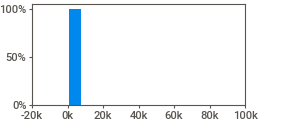
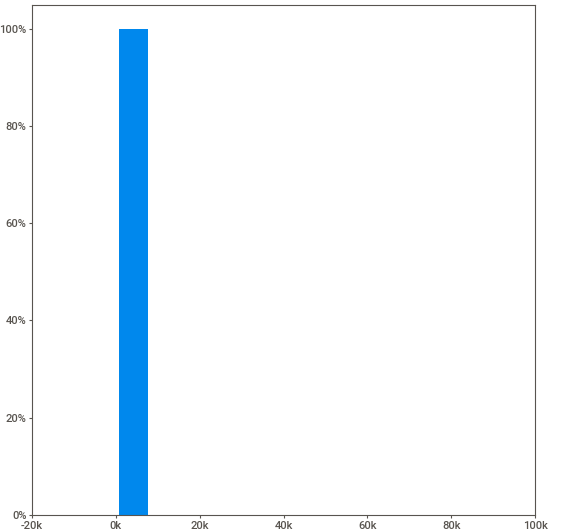
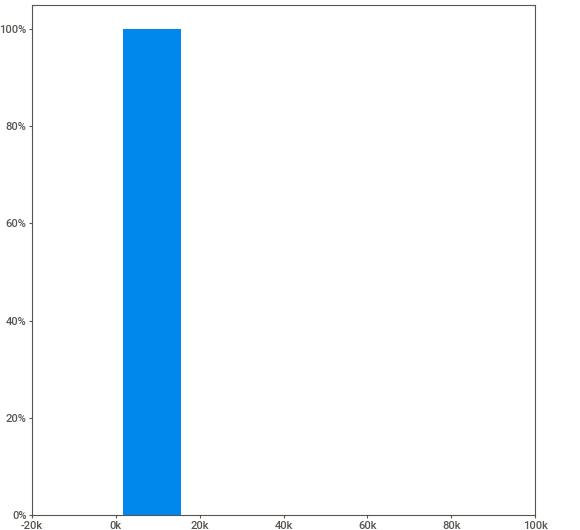
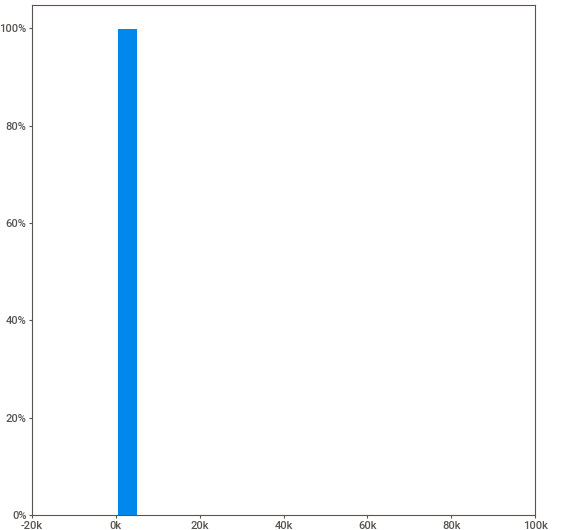
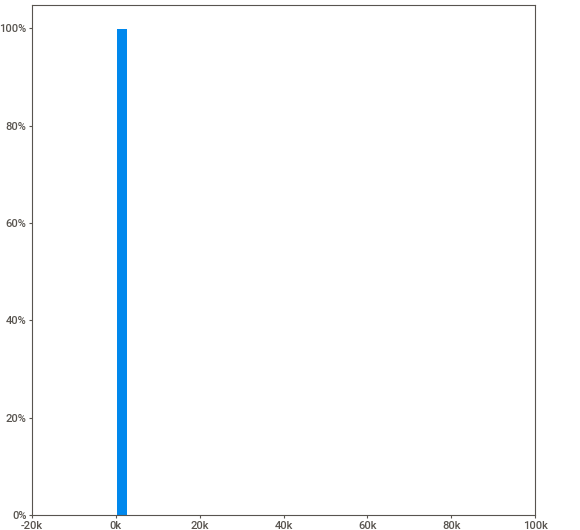
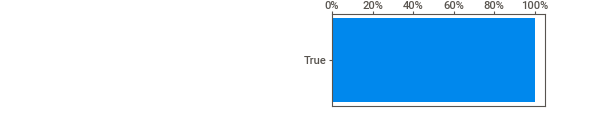
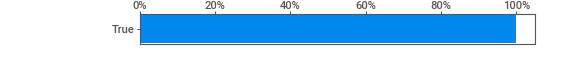
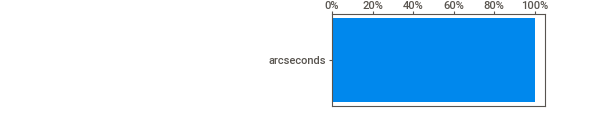
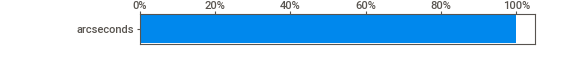
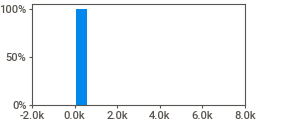
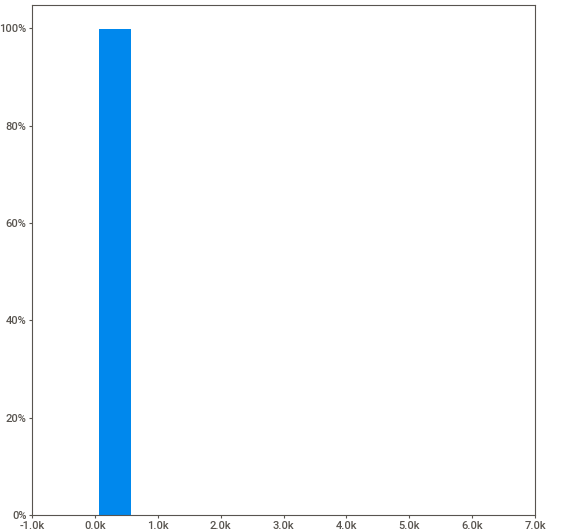
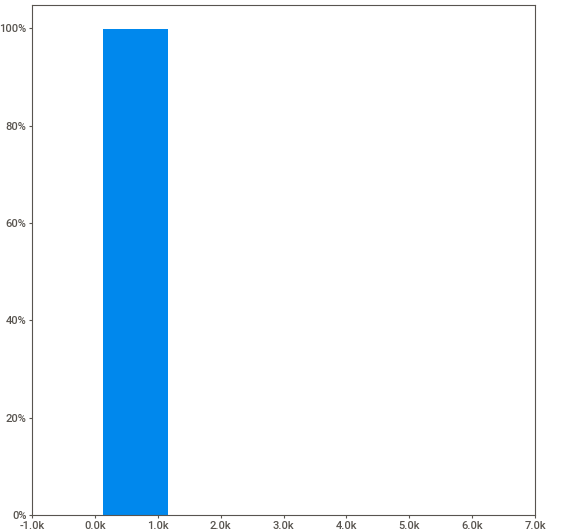
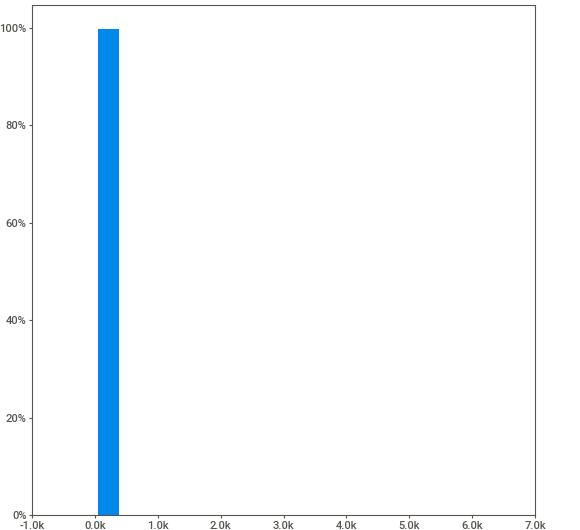
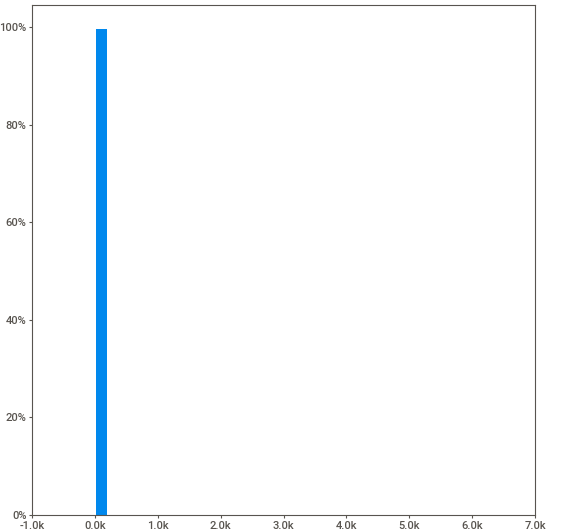
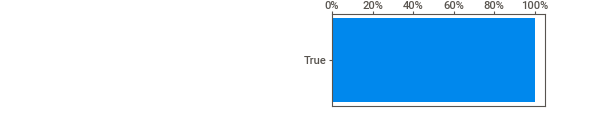
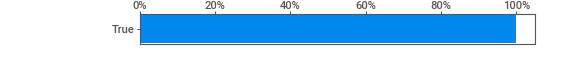
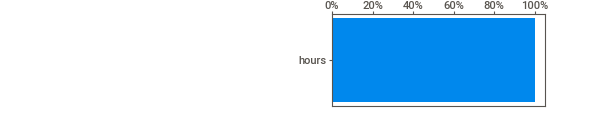
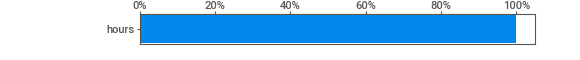
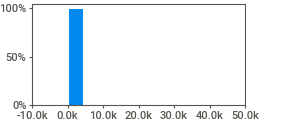
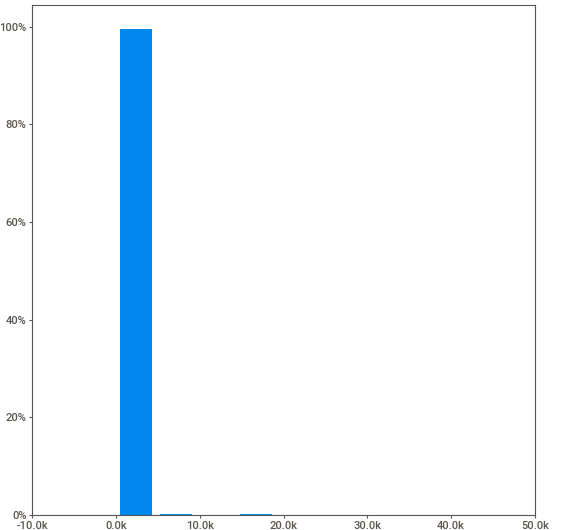
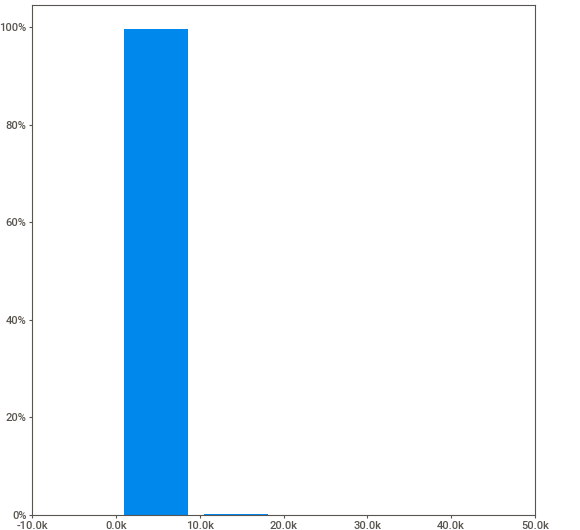
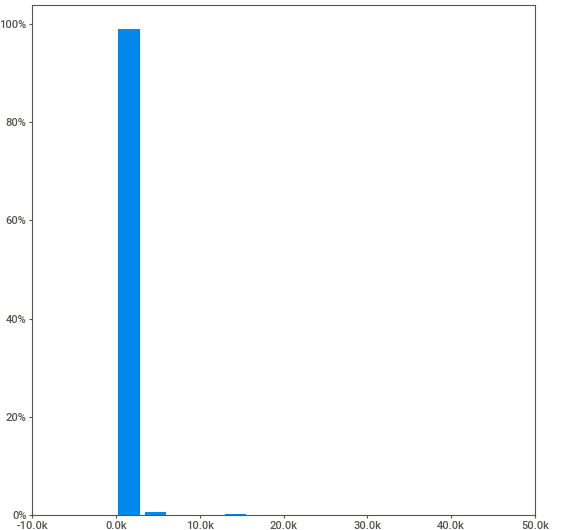
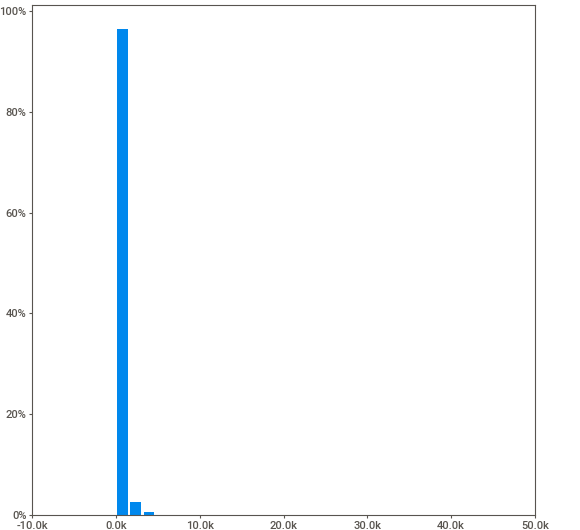
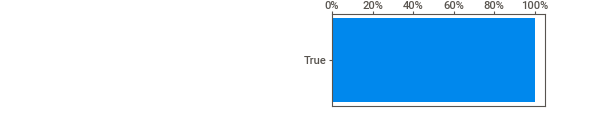
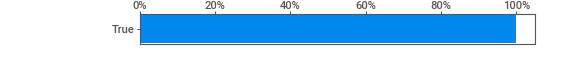
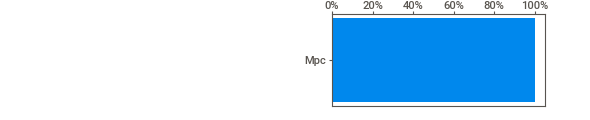
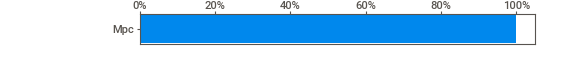
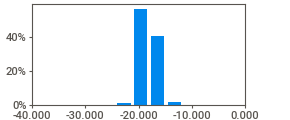
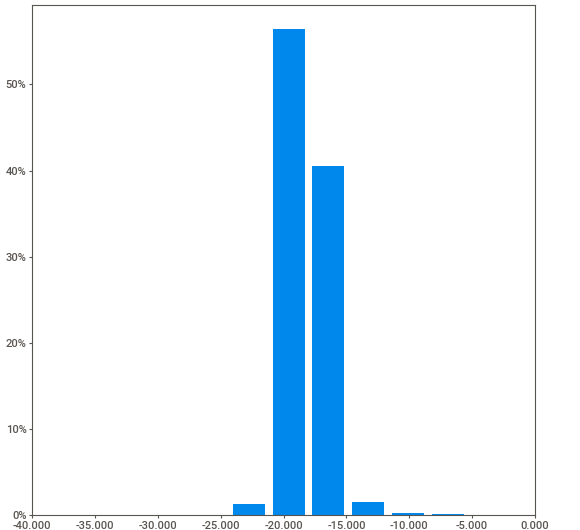
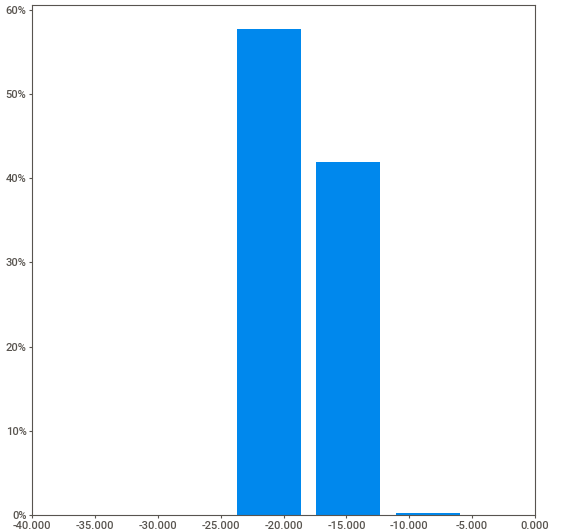
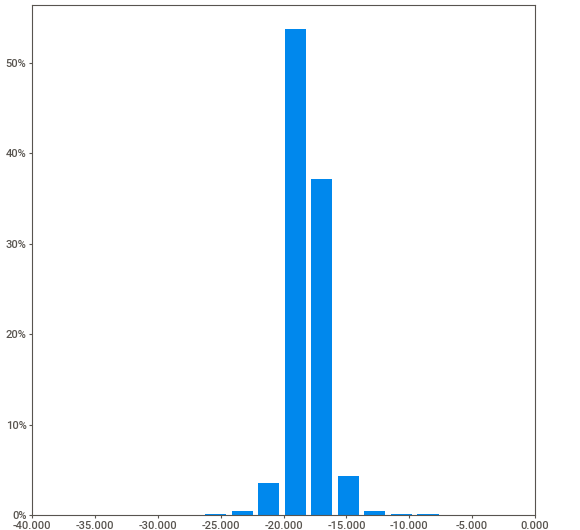
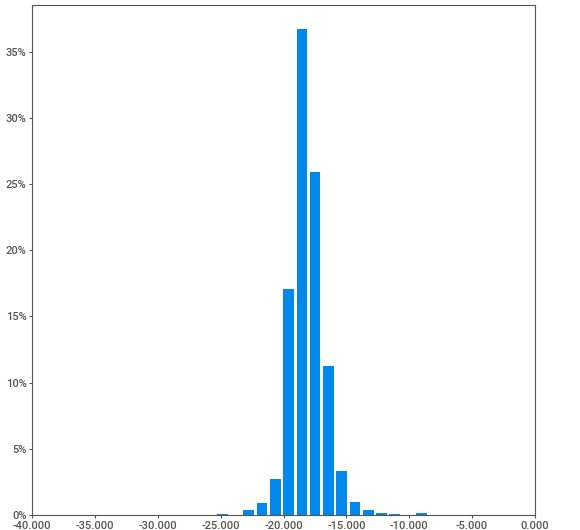
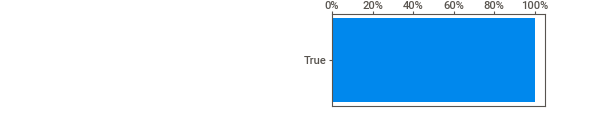
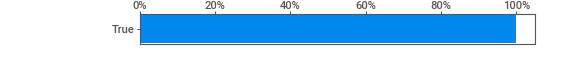
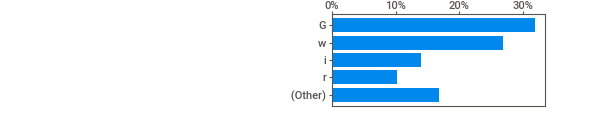
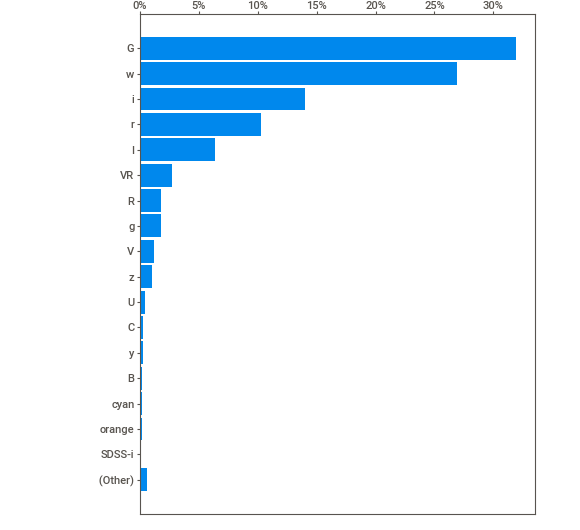
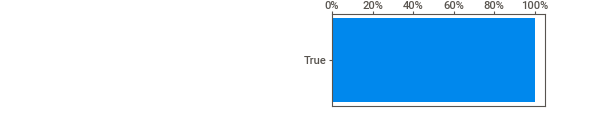
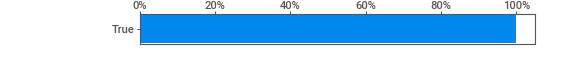
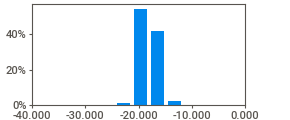
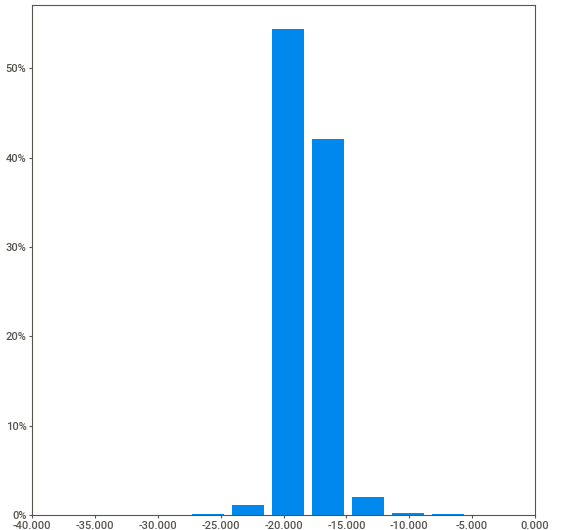
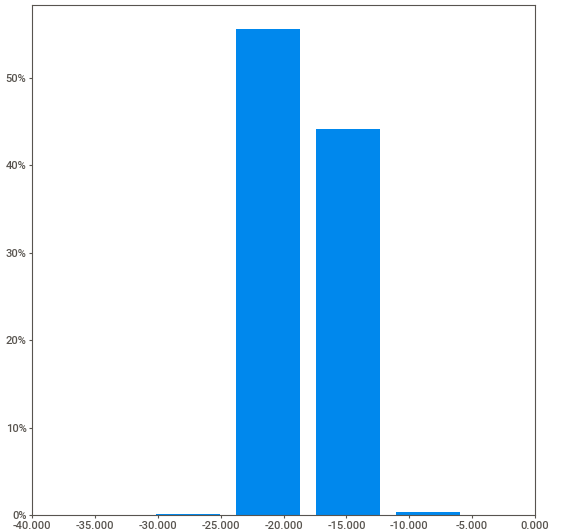
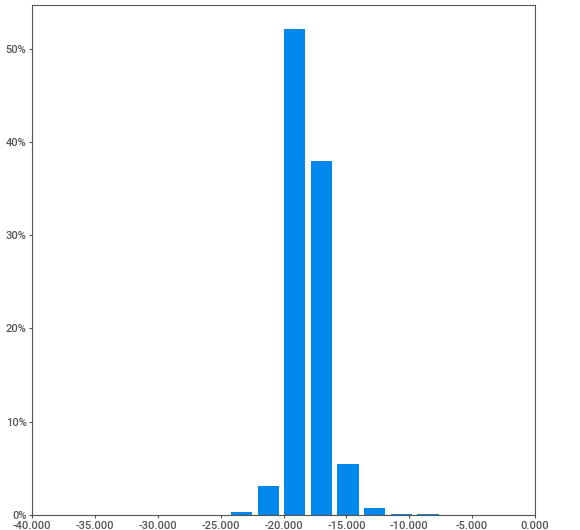
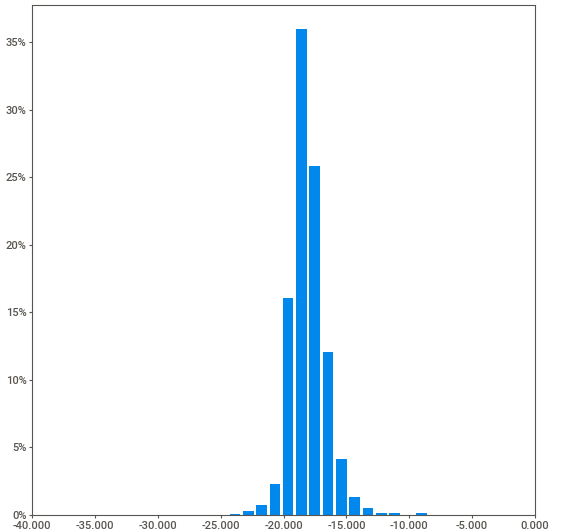
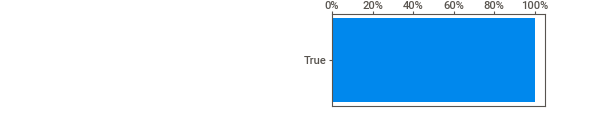
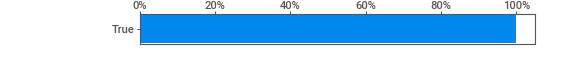
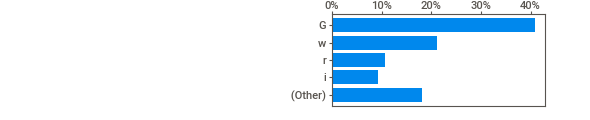
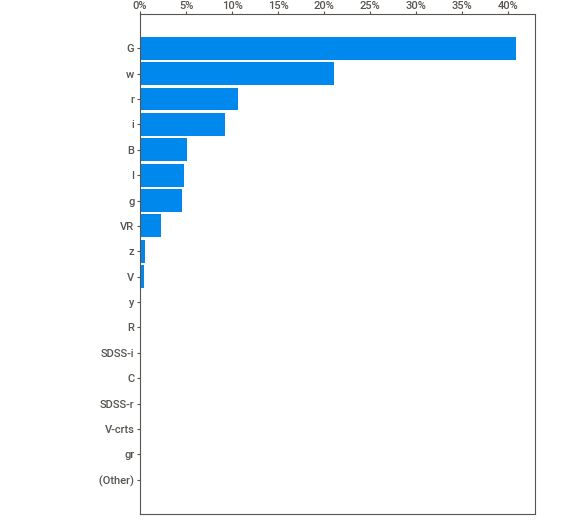
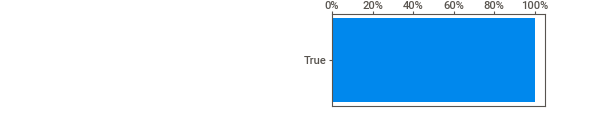
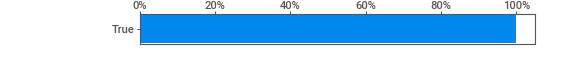
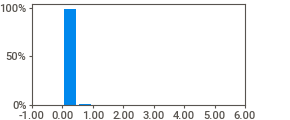
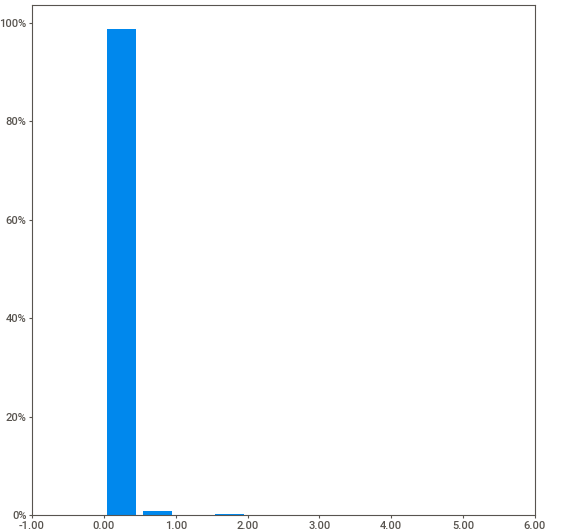
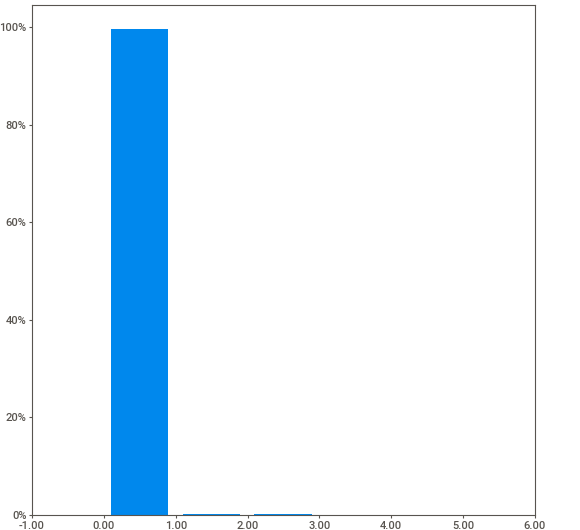
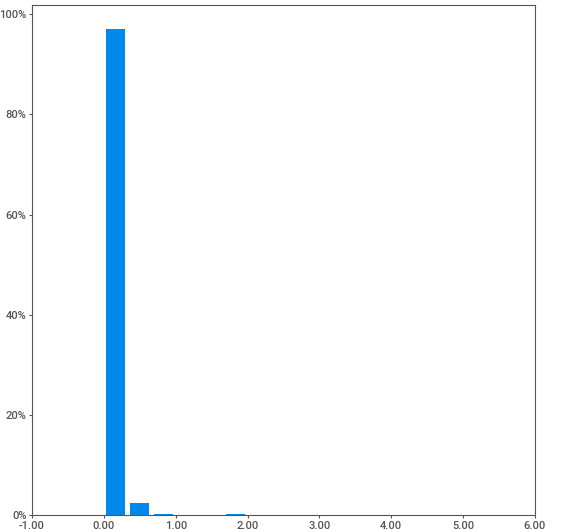
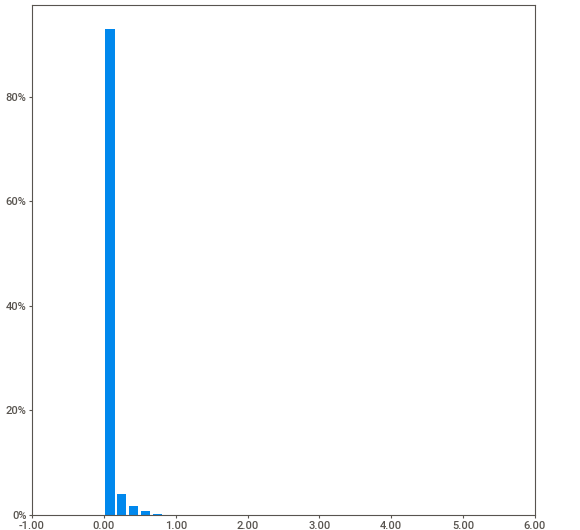
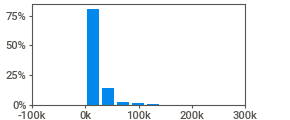
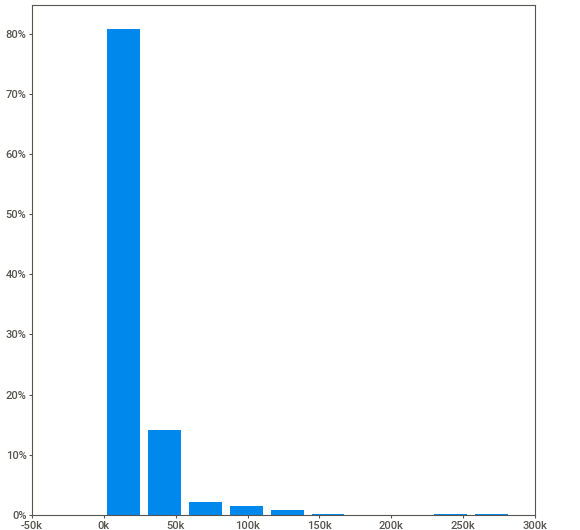
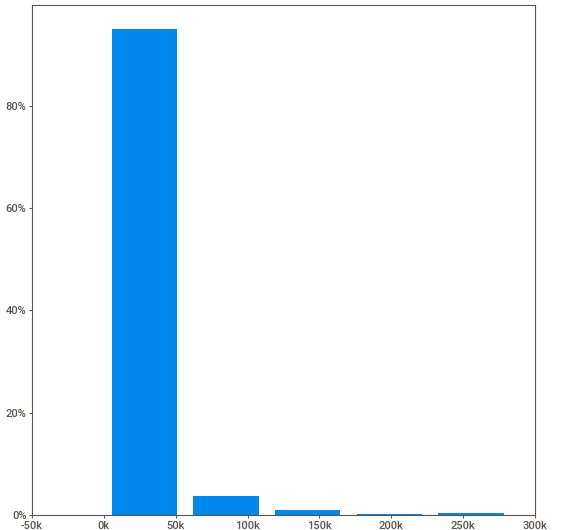
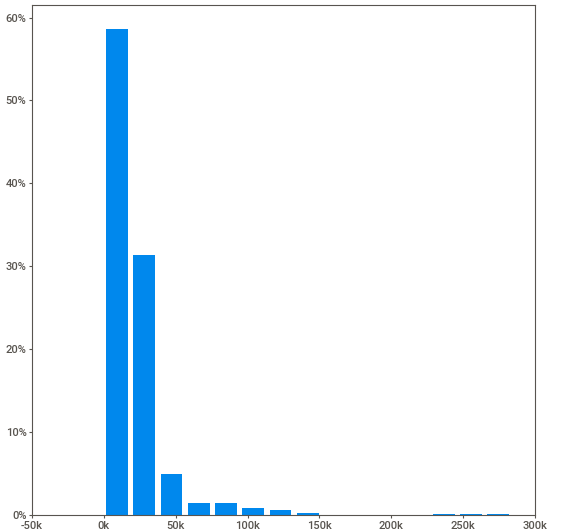
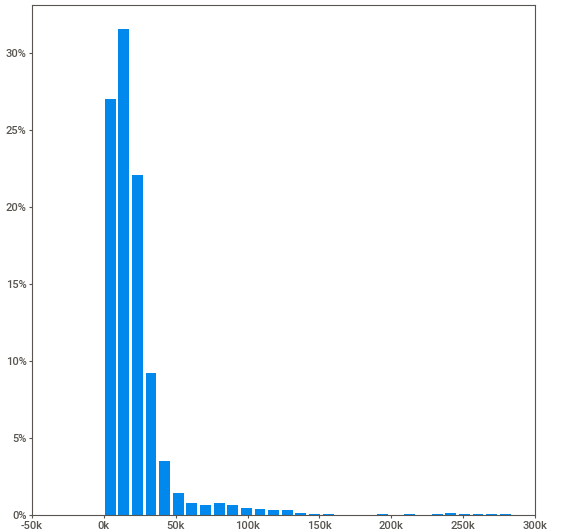
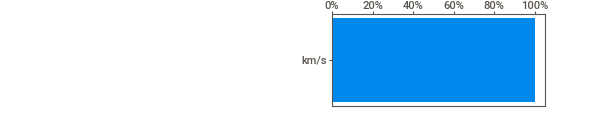
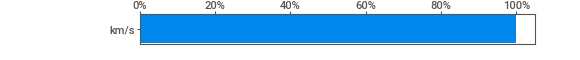
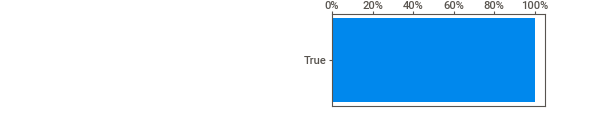
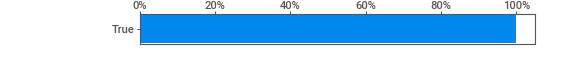
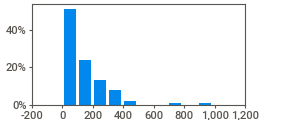
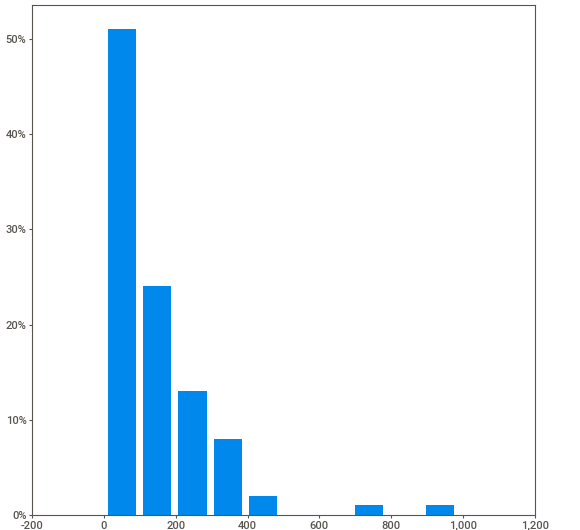
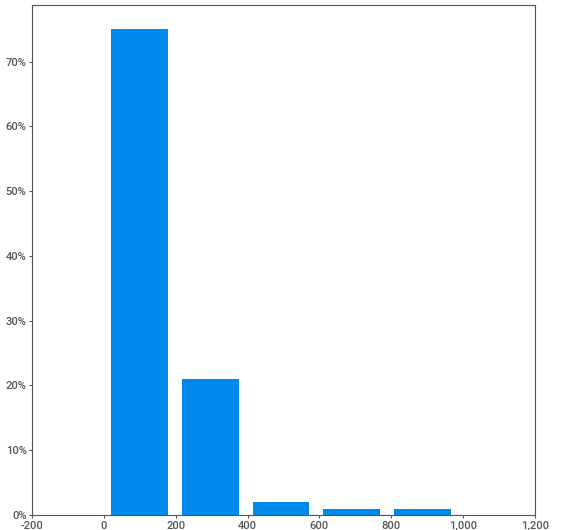
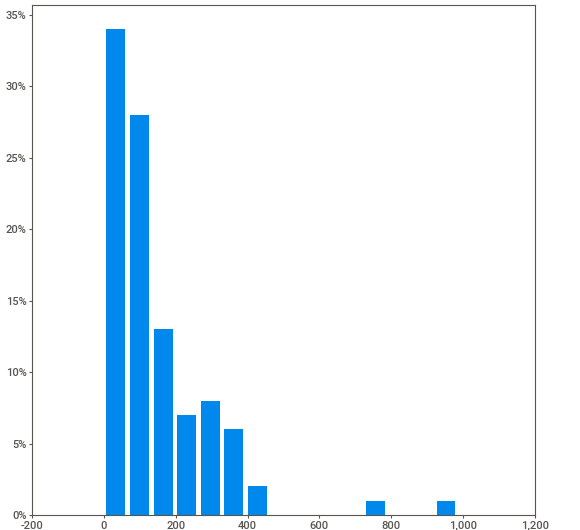
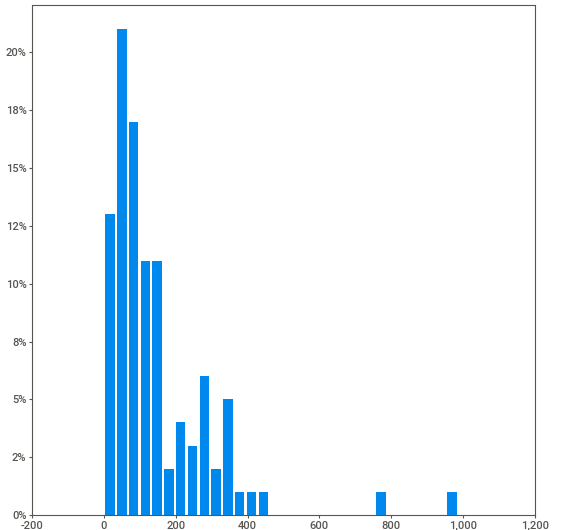
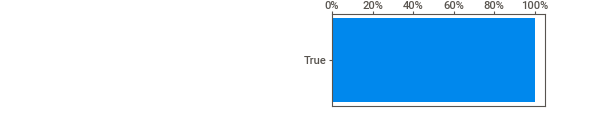
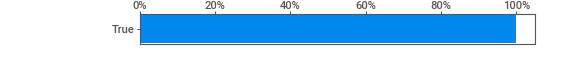
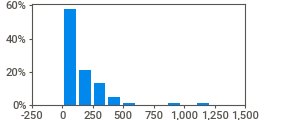
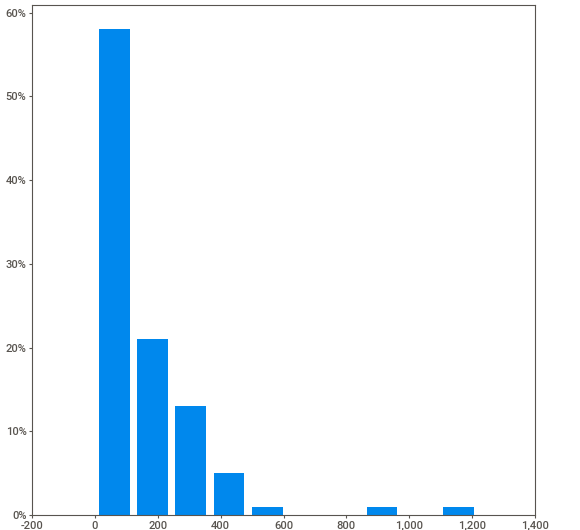
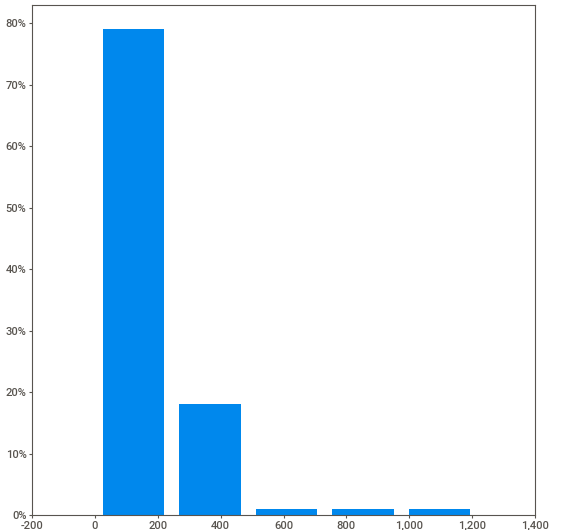
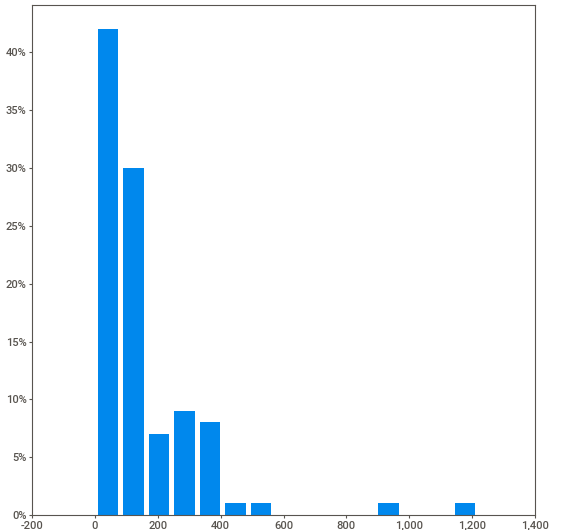
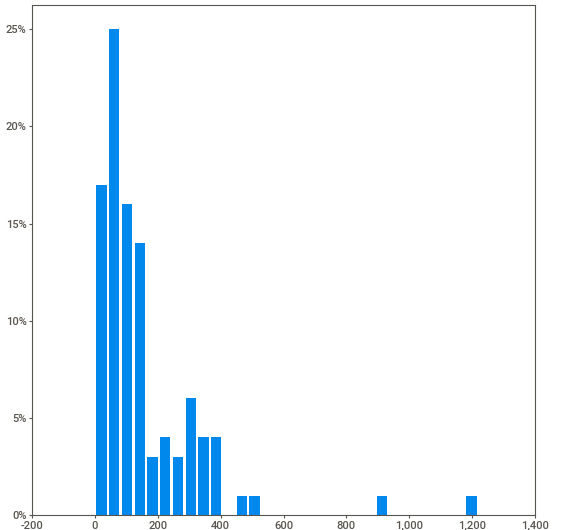
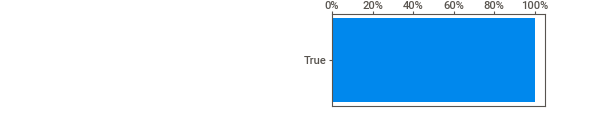
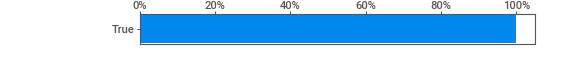
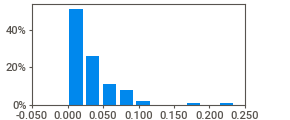
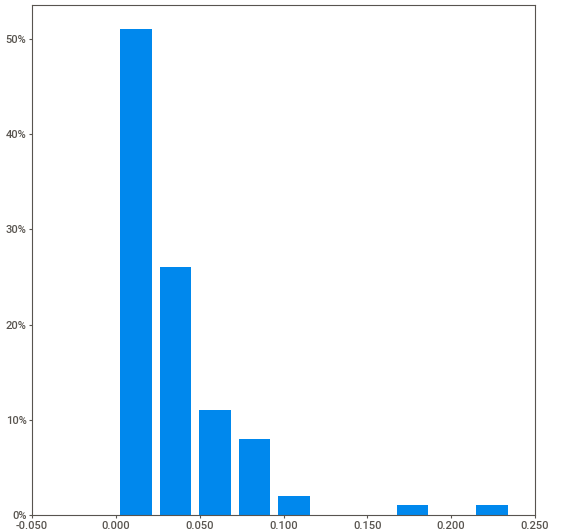
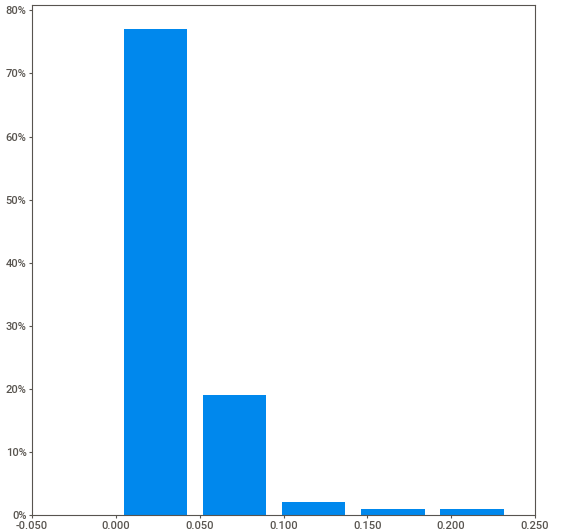
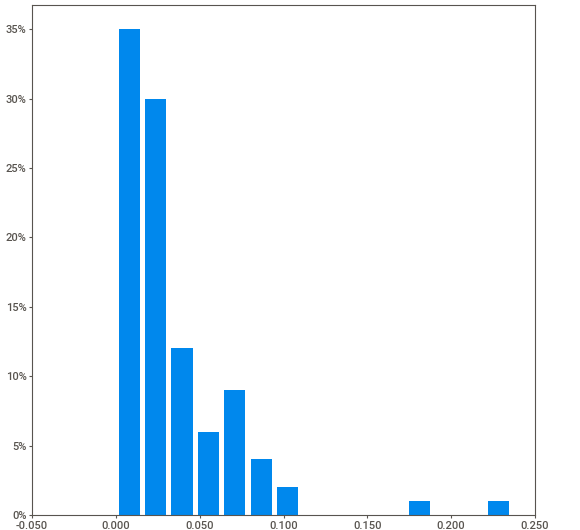
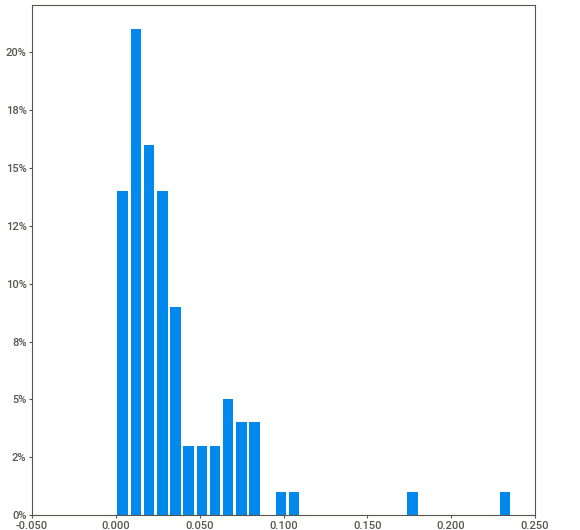
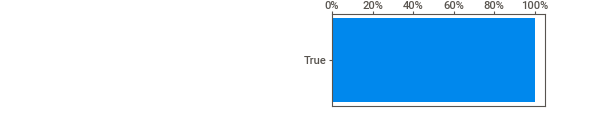
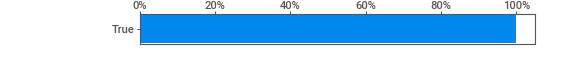
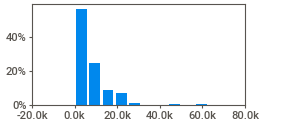
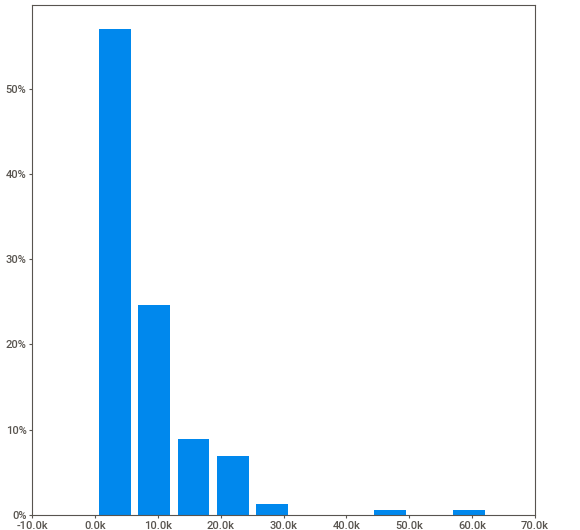
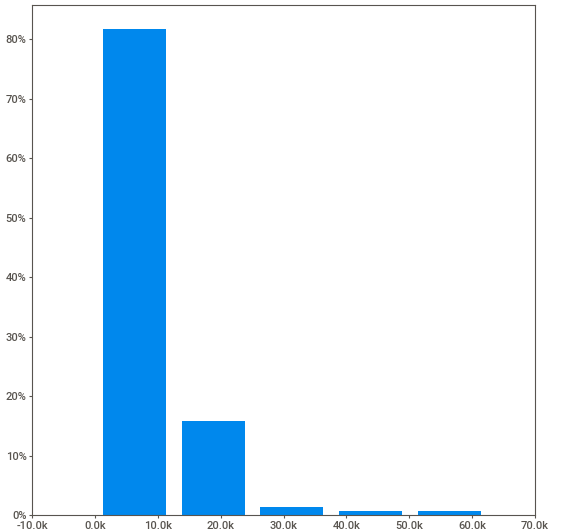
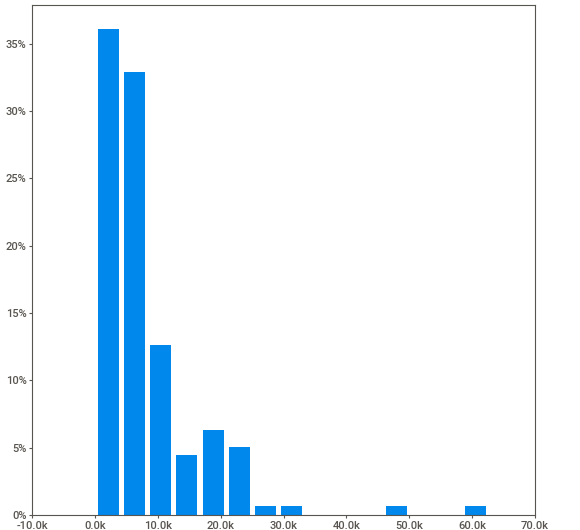
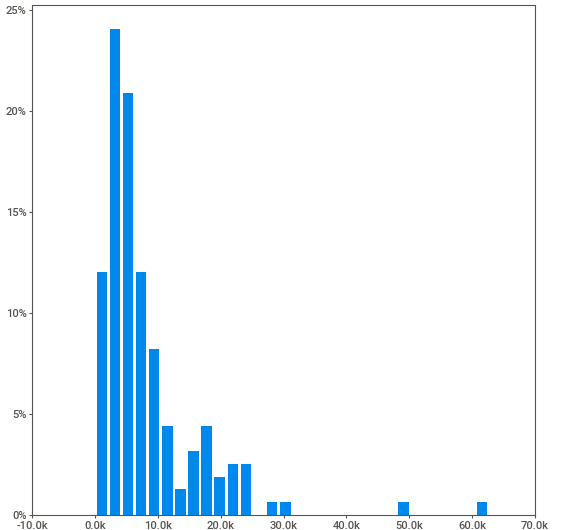
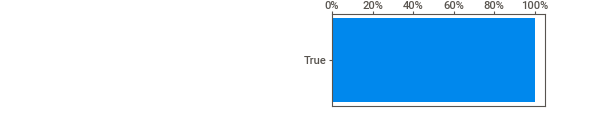
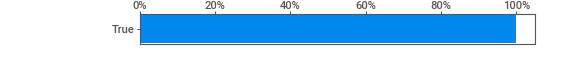
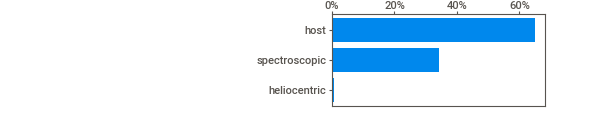
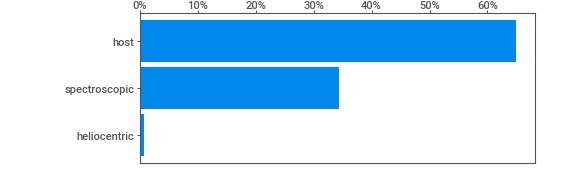
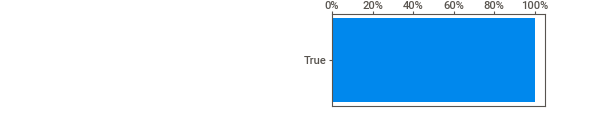
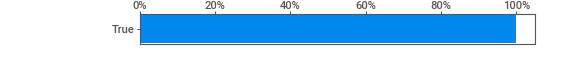
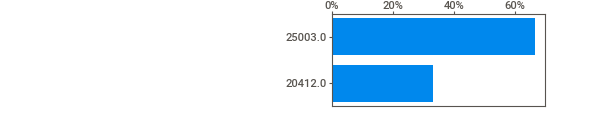
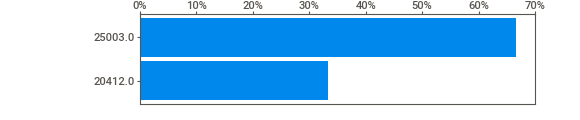
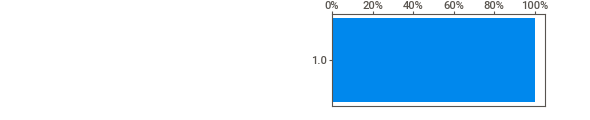
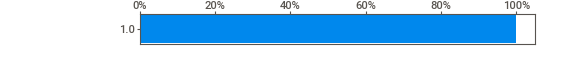
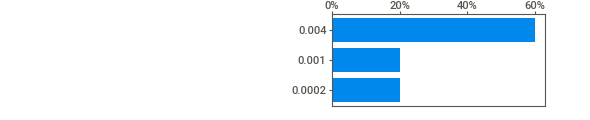
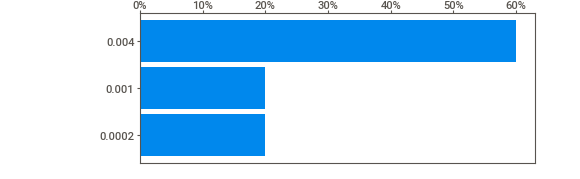
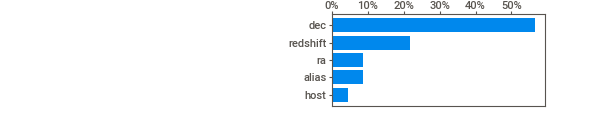
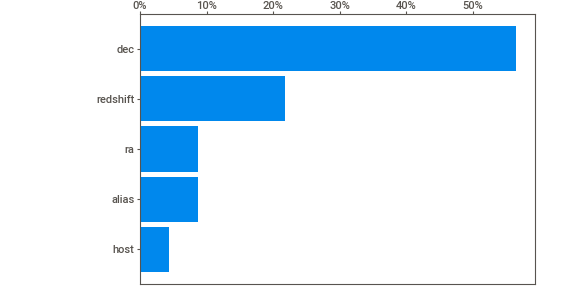
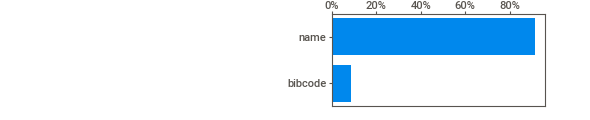
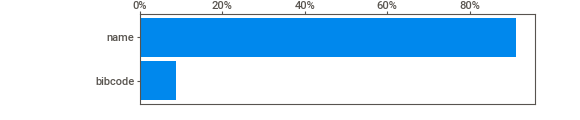
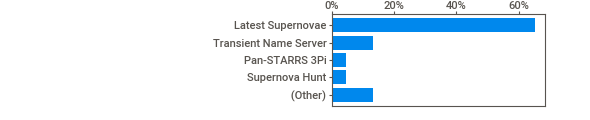
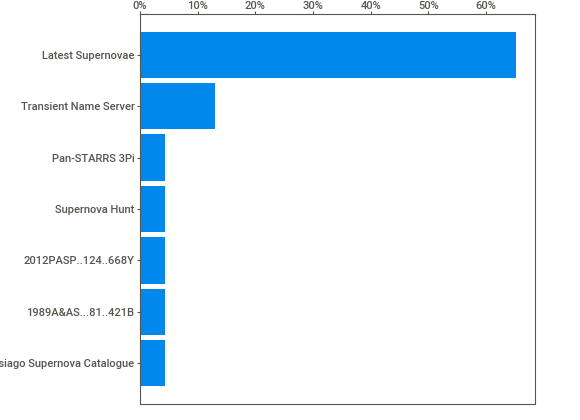
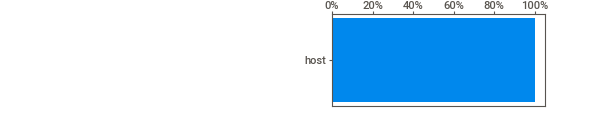
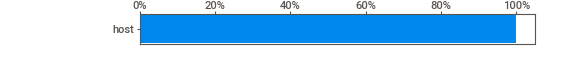
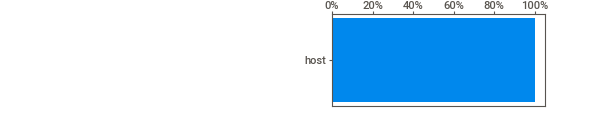
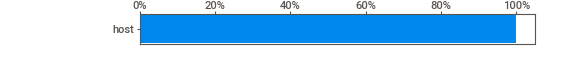
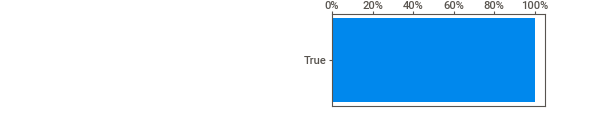
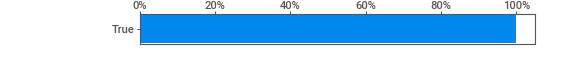
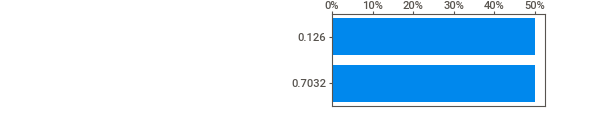
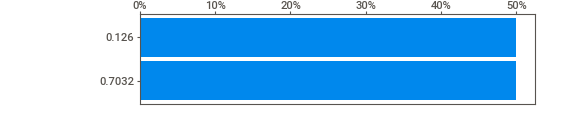
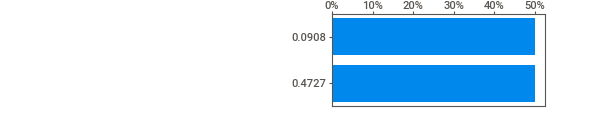
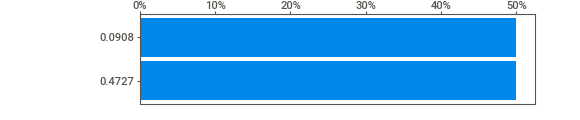
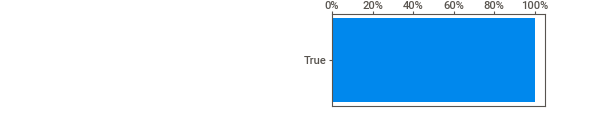
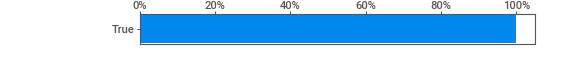
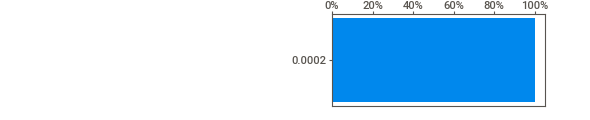
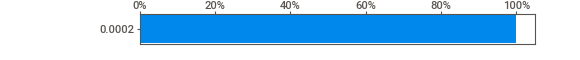
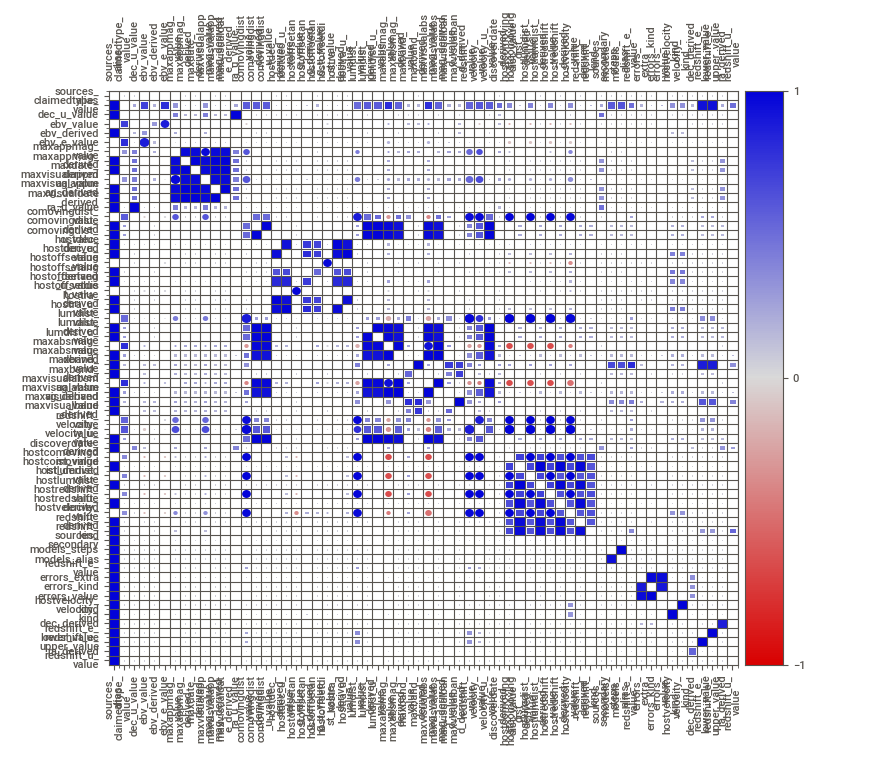
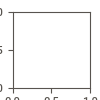

In [16]:
report.show_notebook()

## Non-relational Data Transformation